In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

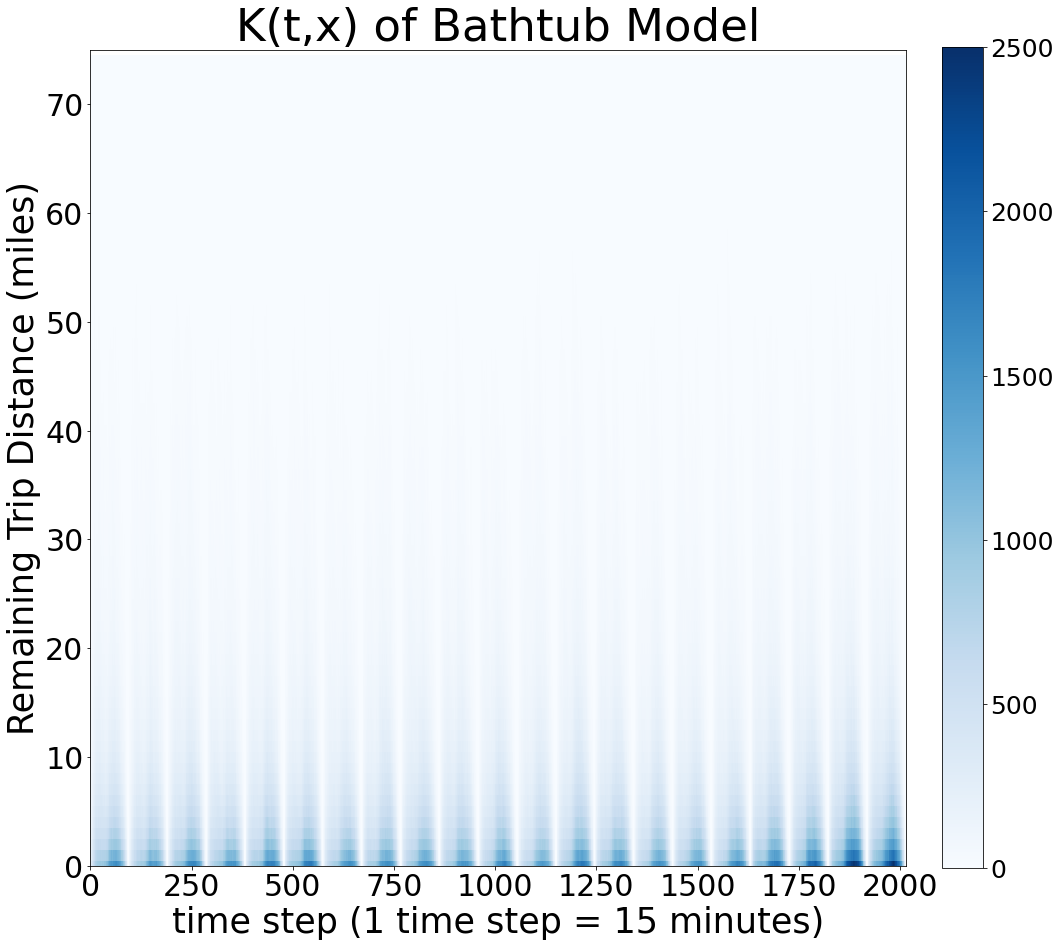

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,10,10,10,10,10,10,10,10,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0177057028253772 0.028834132646094631 0.0065772730046597706 1.2929971516347711
0.011215102856065952 0.019409046433192263 0.0030211592789396416 1.0658718409066772
0.010455029640007692 0.018737881829660685 0.0021721774503547 1.0477543667738092
0.0083535507708751549 0.015102662319532174 0.0016044392222181348 0.9429545557247665
0.0059838571098505206 0.010512116423073545 0.0014555977966274963 0.7885970767153594
0.0050465967219297811 0.0088966615431263652 0.0011965319007331977 0.7242517637830884
0.0049450967567773079 0.0087744484741856827 0.0011157450393689326 0.719266847250354
0.0047871426465758895 0.0085667566972011579 0.0010075285959506206 0.7105859529070659
0.0046377674171721051 0.00827891278072445 0.00099662205361975963 0.6985071952011773
0.0044174775515645913 0.0078332217135142317 0.0010017333896149515 0.679966374060023
0.0042750987514489705 0.0076086364766460735 0.000941561026251868 0.6707934963821085
0.0041325479868819254 0.0074621366485133032 0.00080295932525054753 0.6652197512302

0.0031764610332555097 0.0054424254711013783 0.00091049659540964065 0.5701653162654133
0.0031762689144961445 0.0054454678540567358 0.0009070699749355529 0.570342835953567
0.0031759752855016021 0.0054488199806272961 0.00090313059037590792 0.5705378587226887
0.0031756393065087338 0.0054483839439521606 0.00090289466906530729 0.5705147707097501
0.0031751305598745078 0.0054457526748879059 0.00090450844486110948 0.5703515198377141
0.003174585509593477 0.0054430650344806809 0.00090610598470627338 0.5701683335811726
0.0031742582413556131 0.0054481117794956627 0.00090040470321556352 0.5703948831306304
0.0031737419460230168 0.0054344584707545687 0.00091302542129146475 0.5696075473283844
0.00317344270298379 0.0054375863948155911 0.00090929901115198908 0.5697989903735761
0.0031729861715197216 0.0054401493156162276 0.00090582302742321544 0.5699514334930987
0.0031727840229551297 0.0054348694911008676 0.0009106985548093915 0.56966864936098
0.0031726765044797732 0.0054422639078818089 0.0009030891010777

0.0031470240466082576 0.0053655697561826449 0.00092847833703387059 0.5662778397304628
0.0031468786248645526 0.00536746423843429 0.00092629301129481493 0.5663593271218544
0.0031464811196479504 0.0053575000429871341 0.00093546219630876674 0.5658132543449769
0.003146309578312155 0.0053653184529878642 0.0009273007036364457 0.566175947738647
0.0031462314711634761 0.0053598743501376816 0.00093258859218927086 0.5658881794903735
0.0031462077130719403 0.0053598182502962149 0.00093259717584766538 0.5658776368985682
0.0031461770713906035 0.0053621541395939328 0.00093020000318727385 0.5659908694123159
0.0031461335782784791 0.0053642464351191244 0.00092802072143783384 0.5660836827919624
0.0031460911941151542 0.0053621890276982012 0.00092999336053210693 0.5659773853335929
0.0031460509322371539 0.0053602427633066968 0.00093185910116761123 0.5658787265218872
0.0031460052101434815 0.005359308059720771 0.00093270236056619213 0.5658302709548487
0.0031459346308601406 0.0053604780760007189 0.00093139118571

0.0030692559371386721 0.0053079589264269046 0.00083055294785043933 0.5626421652069751
0.0030690070520797228 0.0053036532617641036 0.00083436084239534155 0.5623881753883675
0.0030687348337954572 0.0052936362630467831 0.00084383340454413148 0.5618969217560039
0.003068515648533963 0.0052999017412643078 0.00083712955580361812 0.5622332200576783
0.00306824557816777 0.0053064248987230505 0.00083006625761248957 0.56258197362379
0.0030680379883947003 0.0053116827695296933 0.00082439320725970775 0.562859259316455
0.0030679125841859929 0.0053107480225362833 0.00082507714583570225 0.5628041010585887
0.0030678700698508411 0.0053060735134410533 0.00082966662626062925 0.5625265261185383
0.0030678108595927362 0.0053062522298293335 0.000829369489356139 0.5625527018648222
0.0030677808449877378 0.0053067718391944588 0.0008287898507810163 0.5625803103171012
0.00306763463986326 0.0053077352546935042 0.0008275340250330158 0.5626421198518804
0.0030673347102655808 0.0053053137070734257 0.00082935571345773575

0.0030473034459152881 0.0052235746190607418 0.00087103227276983427 0.558221508257479
0.0030472134368951559 0.0052195330832879409 0.0008748937905023711 0.5580048659191925
0.0030471079373078735 0.00521819210627653 0.00087602376833921731 0.5579318876592342
0.0030470595387720222 0.00521592008241825 0.00087819899512579487 0.5578245436910031
0.0030470186311483808 0.0052137169382301439 0.00088032032406661759 0.5577292934357471
0.0030469790425932289 0.00521862444546486 0.00087533363972159769 0.5579947585265975
0.0030469474409284165 0.0052172035316991119 0.00087669135015772082 0.5579095942892351
0.0030468855557618944 0.0052143449785626295 0.00087942613296115911 0.5577593391738775
0.0030467062292715572 0.0052083761935517248 0.00088503626499139 0.5574429659561191
0.0030463185615425483 0.0052026803259203796 0.00088995679716471685 0.5571464874733749
0.0030452305758659104 0.0051968682882976474 0.00089359286343417335 0.5568397509615735
0.0030444435756644479 0.005199095730699755 0.00088979142062914113

0.0030235049467143976 0.0051584130770925664 0.00088859681633622872 0.5546641318803648
0.0030234073949227786 0.0051604561293477885 0.00088635866049776853 0.5547716197339947
0.0030232782107961474 0.0051601175806066484 0.0008864388409856466 0.5547516746656778
0.00302317612610281 0.005165351725721439 0.00088100052648418074 0.5550581438500068
0.0030229874793303579 0.0051631062135279694 0.00088286874513274606 0.5549212559188931
0.0030228646879125417 0.0051554203738851841 0.00089030900193989935 0.5545256230492793
0.003022771283068406 0.005155623777182013 0.00088991878895479859 0.5545518089702968
0.0030227391491537514 0.0051563572839435938 0.00088912101436390892 0.5545692660019041
0.0030227007242410908 0.0051561382333196511 0.00088926321516253042 0.554553225929457
0.0030226710936548406 0.0051556424936186427 0.0008896996936910384 0.5545160996938089
0.0030226529191349051 0.0051569935404463425 0.00088831229782346819 0.5545824640741728
0.0030226311253450135 0.0051570591178417575 0.0008882031328482

0.0030144546723394217 0.005129127999124794 0.00089978134555404956 0.5530854171645149
0.0030144063599570016 0.0051331776357634853 0.00089563508415051825 0.553318389147376
0.0030143656493076048 0.0051330384742364179 0.00089569282437879159 0.5532978340861034
0.0030142801789589091 0.0051293727898595156 0.00089918756805830251 0.5531215396632122
0.003014233234740365 0.0051264924624030142 0.00090197400707771585 0.5529679913346435
0.0030141420470036389 0.0051252930974914832 0.00090299099651579436 0.5529282833836658
0.0030140611734989775 0.0051238873344530266 0.00090423501254492872 0.552851605958242
0.0030139267385591566 0.00512510081044157 0.00090275266667674337 0.5529135813463396
0.0030138883705511845 0.00512389221723784 0.0009038845238645291 0.552873265387114
0.0030137987910043361 0.0051279210497271 0.00089967653228157252 0.5530668605324744
0.0030137517426772342 0.0051308235795095745 0.00089667990584489351 0.5532452280510703
0.0030136902913560017 0.0051313561002451725 0.00089602448246683107 

0.0030044330414650436 0.005108072518653084 0.000900793564277003 0.5520764982953074
0.003004366058638532 0.0051113538298346384 0.00089737828744242609 0.5522505244582318
0.0030043192722266306 0.0051128181720936569 0.00089582037235960471 0.5523119407014802
0.0030042591911233836 0.0051127868128339046 0.00089573156941286276 0.5523003259515333
0.0030040995779944159 0.0051143070270500014 0.00089389212893883083 0.5523742936611022
0.0030039824581723816 0.0051101578052067951 0.00089780711113796822 0.5521407065522015
0.0030039123299422212 0.00510931568511694 0.000898508974767502 0.552068991611537
0.0030037575057486514 0.0051097521570942989 0.00089776285440300362 0.5521160434247689
0.0030036842572287495 0.0051107015406732853 0.00089666697378421349 0.5521935568916205
0.0030035324055500525 0.0051106085677132661 0.00089645624338683912 0.5521839256502183
0.0030034656119386793 0.00511061641726142 0.00089631480661593859 0.5521853332581766
0.0030033182356056249 0.0051076443378469862 0.000898992133364264 

0.0029977758503303567 0.00511737555394524 0.00087817614671547336 0.5524672871434161
0.0029977036377209494 0.0051157545076635363 0.00087965276777836256 0.5523738712209912
0.0029976056284153657 0.0051183070806747194 0.000876904176156012 0.5525155798475386
0.0029975545209485932 0.0051152562215547072 0.00087985282034247947 0.5523619716944804
0.0029974577443427066 0.005117895198619527 0.0008770202900658863 0.5524962614434458
0.0029974004986525055 0.005116605608859002 0.00087819538844600877 0.5524130169818261
0.002997341752852759 0.0051144469412666062 0.0008802365644389119 0.5523033521260828
0.0029972761805018072 0.0051141517984786972 0.000880400562524917 0.552284839693384
0.0029971969721185278 0.005115922912244112 0.000878471031992943 0.5523776961578845
0.0029971236951934145 0.0051167661122007244 0.000877481278186105 0.5524286539384066
0.0029970753177174015 0.0051154944712281615 0.00087865616420664124 0.5523598820784561
0.0029970203780615217 0.0051118285522368445 0.00088221220388619878 0.55

0.0029925672542526734 0.0050942843721932347 0.00089085013631211166 0.551307106659703
0.0029925595941113752 0.0050974306704362994 0.00088768851778645063 0.5514598143403849
0.0029925329659611084 0.0050952464924910066 0.00088981943943121052 0.5513575772771224
0.0029925171488362277 0.00509539495832529 0.000889639339347165 0.5513672462098591
0.0029924952537455167 0.0050948736090474494 0.00089011689844358433 0.5513362978298485
0.0029924597204218305 0.0050960971259782582 0.00088882231486540268 0.55139936373725
0.0029924515032866842 0.0050934719198039314 0.00089143108676943683 0.5512327004049509
0.0029924167823047331 0.0050957267048756215 0.00088910685973384431 0.5513619000118037
0.0029923877799019095 0.00509700500991096 0.00088777054989285929 0.5514369648144881
0.0029923656102849275 0.0050974703063368428 0.000887260914233012 0.5514648147625802
0.002992345590372788 0.0050972846192083336 0.00088740656153724225 0.551455529794702
0.0029923063145345413 0.0050969954778303621 0.00088761715123872038 

0.0029892331562440095 0.00508945586874899 0.00088901044373902922 0.5509448093075244
0.0029891730569812135 0.005090352488636654 0.00088799362532577327 0.5510036186668162
0.0029891157706671148 0.0050867004292780528 0.00089153111205617693 0.5508262029549645
0.0029890367717158206 0.0050891922660621916 0.00088888127736944989 0.5509538258250473
0.0029889677601915715 0.0050874871356519358 0.00089044838473120724 0.5508401690308273
0.0029889324245129809 0.0050878945564872408 0.00088997029253872113 0.550870197973818
0.0029889124181667007 0.0050884007723306741 0.00088942406400272758 0.5508859049276617
0.0029888887162011608 0.0050888234789598511 0.00088895395344247053 0.5509194761069779
0.0029888638125709012 0.0050873481407240134 0.00089037948441778893 0.5508433301351228
0.0029888440586013413 0.0050843759639009577 0.00089331215330172521 0.5506883785997472
0.0029888148594253354 0.0050852216108661294 0.00089240810798454158 0.5507305443611155
0.002988781862815401 0.0050865924260214161 0.0008909712996

0.0029852981377722319 0.0050754612450489619 0.00089513503049550209 0.5503296700284149
0.0029852694215620709 0.005073422554103044 0.00089711628902109774 0.5502205431312492
0.002985257155549031 0.0050728518479922257 0.00089766246310583669 0.5501884293751739
0.0029852429369271656 0.0050724606849013917 0.00089802518895293955 0.550168629173373
0.002985227468971782 0.0050727576016588328 0.00089769733628473122 0.5501826784295423
0.0029852083788605853 0.0050740050165281872 0.00089641174119298324 0.5502494813184743
0.0029851801200600474 0.0050754098251794616 0.00089495041494063354 0.550320121240059
0.002985160359464405 0.00507675425535923 0.00089356646356958034 0.5503804826370347
0.0029851401832837162 0.0050763411771068 0.00089393918946063182 0.5503621128779558
0.0029851187031075745 0.0050749458973882956 0.00089529150882685369 0.5502768404512537
0.00298509285035712 0.00507363944220218 0.0008965462585120603 0.5502022672626256
0.0029850558137695027 0.0050746585459532706 0.00089545308158573507 0.5

0.0029809740993770443 0.0050715391955950774 0.00089040900315901135 0.5500046808579729
0.0029809427653329531 0.0050708976830426567 0.00089098784762324924 0.5499806602595573
0.0029809265602120396 0.0050704300157998284 0.000891423104624251 0.5499560787010389
0.0029809043846291349 0.0050707678846865535 0.00089104088457171639 0.5499728062958791
0.0029808860968616362 0.0050701474493343021 0.00089162474438897075 0.5499418723192974
0.0029808653796487726 0.0050696662228402129 0.00089206453645733182 0.5499144943572352
0.0029808482619486094 0.0050691739230976328 0.00089252260079958606 0.5498990085695328
0.0029808295783142393 0.0050698220456525328 0.00089183711097594591 0.5499318806081409
0.0029807973518068158 0.0050698464875627465 0.000891748216050885 0.5499412318259267
0.0029807630530483886 0.0050715088784214282 0.00089001722767534928 0.5500278051691581
0.0029807164154066674 0.0050699296229647821 0.00089150320784855291 0.549935156658617
0.002980669098598664 0.0050716155593120938 0.00088972263788

0.0029756505050611876 0.0050613881144975581 0.00088991289562481669 0.5495330081790686
0.0029756245808919661 0.0050603341401186342 0.00089091502166529807 0.5494695152978764
0.0029755666948112977 0.00506210211559502 0.00088903127402757481 0.5495690428868243
0.0029755126810938762 0.0050613860577332906 0.00088963930445446209 0.5495599933504612
0.0029754539845193344 0.0050625803429931275 0.00088832762604554132 0.5496152623053675
0.0029754341269079723 0.0050647305376447273 0.00088613771617121733 0.5497264211416764
0.0029754079923229484 0.0050590207627747913 0.00089179522187110582 0.5494035403607626
0.002975361419851844 0.0050599541597291259 0.000890768679974562 0.5494573637093462
0.0029753149069146963 0.005060526512359026 0.00089010330147036641 0.5494983992703596
0.0029752486361647131 0.0050611859210227825 0.00088931135130664355 0.5495215641979103
0.0029751783650767481 0.0050580974553769715 0.00089225927477652451 0.5493471850132335
0.0029751204446418671 0.0050582906698122326 0.00089195021947

0.0029721393400675717 0.0050552028648285343 0.00088907581530660892 0.5492466042570656
0.002972131590655147 0.0050542064198062847 0.00089005676150400912 0.5491977709264441
0.0029721151187376465 0.0050553243186725961 0.00088890591880269728 0.5492531167968026
0.0029721108315896791 0.0050568793743534582 0.00088734228882590021 0.5493413103400994
0.0029720870797518366 0.0050554072669573786 0.0008887668925462945 0.5492590055207401
0.0029720515034985847 0.0050551311681465046 0.00088897183885066516 0.5492397463919938
0.0029720139061219573 0.0050551850306542806 0.0008888427815896342 0.5492469307275113
0.0029719815555442207 0.0050554260359820828 0.00088853707510635875 0.5492591858375319
0.0029719487407872569 0.0050565278700500085 0.00088736961152450556 0.5493166831896533
0.002971921818458598 0.005056624963823992 0.00088721867309320373 0.5493154267952172
0.0029719017206388714 0.0050543678296121643 0.000889435611665578 0.5491860637681034
0.0029718845151794843 0.0050570734840589453 0.000886695546300

0.0029678266478751192 0.0050483107614285958 0.000887342534321643 0.5488831708891944
0.0029677889852758729 0.0050485862394997246 0.000886991731052021 0.5488911198842803
0.0029677405350780096 0.0050492336065297676 0.00088624746362625214 0.548919240153296
0.0029677055250157949 0.005050567677607273 0.0008848433724243165 0.5489835190077872
0.0029676590269007781 0.0050512555593222111 0.000884062494479345 0.5490121944146081
0.0029676011739568657 0.005050945516244203 0.00088425683166952864 0.5490052159402458
0.00296756546298758 0.0050510904191905246 0.00088404050678463476 0.5489950761247919
0.0029675410912620437 0.0050505411442909494 0.00088454103823313842 0.5489660793296136
0.0029675269364659931 0.0050508150909711995 0.00088423878196078635 0.5489805417629744
0.0029675053278240284 0.0050505306249794676 0.00088448003066858908 0.5489645503684669
0.0029674880381425654 0.005051157474559486 0.00088381860172564444 0.5490003061458095
0.00296747189638467 0.0050511971881087659 0.000883746604660574 0.54

0.0029645488575935439 0.0050461285009097412 0.00088296921427734678 0.5487035019209779
0.0029645175813426054 0.0050467094019404123 0.00088232576074479831 0.5487344910586474
0.0029644682280165389 0.0050460886118761884 0.00088284784415688944 0.5487023251995442
0.0029644057077368564 0.0050467680791277955 0.00088204333634591694 0.5487408185042526
0.0029643473087782608 0.0050461564018205963 0.00088253821573592564 0.5487258708843346
0.0029643011340249152 0.0050445736368050021 0.00088402863124482792 0.5486289292238412
0.002964239638845578 0.0050448901246898173 0.00088358915300133843 0.5486494653812646
0.0029642126587170448 0.0050463332802765746 0.00088209203715751514 0.5487238732901747
0.0029642009441382382 0.0050447412887191078 0.00088366059955736825 0.548650356609854
0.0029641616836270758 0.0050453149331406129 0.00088300843411353886 0.5486623162337498
0.0029641442050949581 0.0050460975476850894 0.00088219086250482693 0.5487074829671321
0.0029641183302545173 0.0050461822226875435 0.0008820544

0.0029593849886825254 0.0050345694883673995 0.00088420048899765121 0.5481134405847503
0.0029593613171984782 0.0050319542266728029 0.00088676840772415394 0.5479569858411547
0.0029593275808711779 0.0050343773102185215 0.00088427785152383391 0.5480980416147827
0.0029593112607108497 0.0050328697447245795 0.00088575277669711945 0.5480199993602403
0.0029592882332867064 0.0050344542153984394 0.00088412225117497317 0.5481114154468373
0.0029592612789213217 0.0050339089062483126 0.0008846136515943306 0.5480853037709265
0.0029592328890165349 0.00503432692338339 0.00088413885464967961 0.5480959938247119
0.0029591701687389682 0.0050351484487337244 0.000883191888744212 0.5481478230044037
0.0029590935120472743 0.0050340904513571181 0.0008840965727374303 0.5480972595776351
0.0029590418661350408 0.0050349571202421466 0.00088312661202793465 0.5481292323892137
0.002959005891230587 0.0050358454515600122 0.0008821663309011616 0.5481738788686985
0.0029589937772458753 0.0050359126144023164 0.0008820749400894

0.002955884790678303 0.0050281607219852982 0.000883608859371308 0.5477707777477824
0.0029558398240328962 0.0050269637473689824 0.00088471590069681021 0.547697913585575
0.0029557859194420427 0.0050275143102008089 0.00088405752868327668 0.5477208444629538
0.0029557526515031751 0.0050251593325046544 0.00088634597050169536 0.547581220224947
0.002955711045652181 0.0050222012187548576 0.00088922087254950436 0.5474224707829186
0.0029556703699107735 0.00502352785659206 0.00088781288322948681 0.5474999646642864
0.0029556319515438613 0.0050226682141858922 0.00088859568890183049 0.5474517107333756
0.002955587522152242 0.0050212725202980757 0.00088990252400640818 0.5473785936159344
0.0029555182622723855 0.0050236325550106252 0.0008874039695341455 0.5474940715384112
0.0029554513950363565 0.0050228850706048886 0.00088801771946782479 0.5474516299022789
0.0029554001190761634 0.0050244661562985106 0.00088633408185381638 0.5475453493648959
0.0029553311337984353 0.00502389687307909 0.00088676539451778072

0.0029502810097714496 0.0050234594356670615 0.00087710258387583781 0.5475032373107961
0.0029502518266610713 0.0050180636130758242 0.00088244004024631828 0.5472400666191756
0.002950168074732916 0.0050232157248033182 0.00087712042466251371 0.5475291208816202
0.0029501254457352569 0.00501707513386627 0.00088317575760424435 0.5471958835212952
0.0029500754420941572 0.0050187823074860144 0.00088136857670230006 0.5473011707321878
0.0029500277549241944 0.0050179101336333947 0.00088214537621499371 0.5472625022741323
0.0029499787591302233 0.0050164082125151166 0.00088354930574533017 0.5472046394888155
0.0029499367674467947 0.0050150509591497848 0.00088482257574380458 0.5471441735116703
0.002949899111777701 0.005014539648900718 0.00088525857465468418 0.5471068297953523
0.002949863635056111 0.0050138414586675681 0.000885885811444654 0.5470708977071943
0.0029498329390176929 0.005015300753184725 0.00088436512485066076 0.547144125352567
0.002949800800871837 0.0050171775827232519 0.000882424019020422 

0.002946096339563989 0.0050060569297177082 0.00088613574941026944 0.5466690027339112
0.0029460748678068406 0.005007284439328864 0.000884865296284817 0.5467295641369174
0.0029460430050286556 0.0050074091299341346 0.000884676880123177 0.5467289690273714
0.0029460020351058155 0.005007816018031663 0.0008841880521799683 0.5467502032715037
0.00294594403831918 0.005008950936233522 0.0008829371404048378 0.5467994757335314
0.0029459064693514625 0.0050057848931479108 0.00088602804555501426 0.5466464960484988
0.0029458568523653078 0.0050068375451381283 0.00088487615959248738 0.5466935380551428
0.0029458295583702633 0.005006395457952049 0.00088526365878847761 0.5466740864576957
0.0029457869454925494 0.00500470201959214 0.00088687187139295845 0.5465942780018611
0.0029457260147026558 0.0050043472159339158 0.00088710481347139549 0.5465854004881221
0.0029456719209329757 0.0050028030903407159 0.00088854075152523511 0.5465049032030167
0.0029456305277464211 0.0050047526780316372 0.000886508377461205 0.54

0.0029426437153328155 0.0049971115278149552 0.000888175902850676 0.5462453268557086
0.0029425859032628913 0.0049957970966294282 0.00088937470989635477 0.546171724677704
0.0029425297735495093 0.0049950660254947906 0.00088999352160422786 0.5461422244113231
0.0029424873372953164 0.0049943510961778645 0.00089062357841276842 0.546100958441328
0.0029424388963272142 0.004991192828218644 0.000893684964435784 0.5459090354767567
0.0029423898135835049 0.0049931839365559266 0.000891595690611083 0.5460354332234593
0.0029423495978230761 0.00499237542614321 0.00089232376950294215 0.5459950509660292
0.0029423028087321914 0.0049935609665648873 0.00089104465089949578 0.5460469605340201
0.0029422617616157937 0.0049916543524854548 0.00089286917074613231 0.5459408879522931
0.0029422083413795253 0.0049911084119272416 0.00089330827083180923 0.5459008494394227
0.0029421748790869856 0.004992902426690953 0.00089144733148301841 0.5459951561482647
0.0029421550354084471 0.0049923389744026712 0.00089197109641422337

0.0029366720829298604 0.0049751050986699937 0.00089823906718972753 0.5450822127155331
0.0029364717661008012 0.0049773726891093736 0.00089557084309222878 0.5452043795522039
0.0029363295797952224 0.0049785753028575921 0.00089408385673285225 0.5452976629891095
0.00293612614061038 0.0049744897079623991 0.00089776257325836111 0.5450811514423015
0.0029360110407119096 0.00497745776939866 0.00089456431202515965 0.5452226651110809
0.0029358957714593543 0.0049794448825248722 0.00089234666039383665 0.5453152733212011
0.0029357881005665832 0.0049806875087830514 0.00089088869235011533 0.54541234806971
0.0029357142168225958 0.0049764901949681554 0.00089493823867703578 0.5451766511034828
0.0029355572732863706 0.0049775714984180838 0.00089354304815465724 0.5452286053577706
0.0029354222358398386 0.0049770510500668263 0.0008937934216128509 0.5452039901591215
0.0029352765681927855 0.0049740523134145665 0.00089650082297100411 0.5450286832885656
0.0029351148998137083 0.0049789402173680015 0.000891289582259

0.0029270694822309882 0.0049592158341605656 0.00089492313030141088 0.5442262001754744
0.0029270451697251515 0.0049555808569715469 0.00089850948247875619 0.5440456617776792
0.0029269399962981225 0.0049607358863155877 0.00089314410628065692 0.5443227737079603
0.0029268640540224388 0.0049611903249556734 0.00089253778308920383 0.5443404207521454
0.0029267139007233094 0.004962945150831656 0.00089048265061496268 0.5444283580969417
0.0029265373696197219 0.0049632371989739273 0.00088983754026551677 0.5444539562146955
0.0029264070663382116 0.0049663614893567694 0.0008864526433196542 0.5446157532671978
0.002926304826368993 0.0049680883014945106 0.00088452135124347537 0.5447179990187104
0.0029262010766379267 0.0049655162066706967 0.000886885946605157 0.5445805710194965
0.0029261519495544872 0.0049638142673960606 0.00088848963171291365 0.5444830073353586
0.0029260957602826976 0.0049648856429442877 0.0008873058776211071 0.5445478208000294
0.00292604329526117 0.0049658351716266261 0.0008862514188957

0.0029173466343686027 0.0049383075810950552 0.0008963856876421499 0.5431100374939929
0.0029172612777825882 0.0049355267199311572 0.00089899583563401878 0.5429716225372261
0.0029171203312734718 0.004934968083537176 0.000899272579009768 0.5429300261230792
0.0029170223584130636 0.00493405563361475 0.00089998908321137769 0.5428786981671982
0.0029168683264984971 0.0049347471524128564 0.00089898950058413772 0.5429165073647189
0.0029167742311514595 0.0049343478961371336 0.00089920056616578587 0.542904487830241
0.0029166891990086421 0.0049369811522007728 0.00089639724581651108 0.5430458163421654
0.0029166247261097193 0.0049369394232619086 0.00089631002895753016 0.5430502242224536
0.0029165836326424414 0.0049363713576041045 0.00089679590768077823 0.5430156692332896
0.0029165484288268817 0.0049375056143428795 0.00089559124331088365 0.5430865363016817
0.0029165130844551529 0.0049372925542145937 0.000895733614695712 0.5430755021959317
0.0029164630437533215 0.00493701333476685 0.0008959127527397929

0.0029092076170525328 0.0049235597220623675 0.00089485551204269845 0.5422801406556842
0.0029091276265499626 0.0049226708329636335 0.00089558442013629158 0.5422227968004375
0.0029090689222179035 0.0049202526435051606 0.00089788520093064686 0.5420749838615742
0.0029090190017859179 0.00491851919860375 0.00089951880496808533 0.5419762207300072
0.0029089467933440891 0.0049160934992158647 0.00090180008747231392 0.5418460075021027
0.0029088692266001611 0.0049124338683771791 0.00090530458482314261 0.5416592827466076
0.00290880087250325 0.0049112823895142571 0.00090631935549224279 0.5416059183208619
0.0029087406580563203 0.0049107528790312445 0.00090672843708139634 0.5415882243205575
0.00290868372014651 0.0049096026851655475 0.00090776475512747317 0.5415332716815484
0.0029086185147426478 0.0049124478904591859 0.00090478913902610934 0.5416888378780302
0.0029085756701953116 0.0049140351889838041 0.00090311615140681919 0.5417695681845505
0.0029085376295070607 0.0049142588282517809 0.00090281643076

0.0029033516894080916 0.0049011600115253587 0.00090554336729082425 0.5410867194542391
0.0029032559945658034 0.0049001674375057161 0.00090634455162589026 0.541020053754315
0.0029031874716907288 0.0049018136684988341 0.0009045612748826233 0.5411170600800697
0.0029031370550286727 0.0049030478503477182 0.00090322625970962721 0.5411922221062954
0.0029030988670204253 0.0049018749007781436 0.00090432283326270671 0.5411407710512338
0.0029030644409605687 0.0049025893895550208 0.0009035394923661166 0.5411717284401725
0.0029030236641514528 0.004902637870260013 0.00090340945804289233 0.5411770993110651
0.0029029793328683058 0.0049017494475265969 0.00090420921821001516 0.5411223537166588
0.002902936870087009 0.0049015261187251909 0.00090434762144882719 0.5411159896805786
0.002902886663783751 0.0049007039549549165 0.00090506937261258553 0.5410803340027747
0.002902848064656305 0.004900823502183075 0.00090487262712953551 0.5410855558569468
0.0029028078639556552 0.0049018307243113343 0.0009037850035999

0.0028980262953218891 0.0049067849236330389 0.00088926766701073886 0.5412844290496014
0.0028980003076194126 0.004906354913757442 0.00088964570148138339 0.5412609018144434
0.002897994072573577 0.0049047942526883057 0.00089119389245884844 0.5411599322015164
0.0028979451003432514 0.0049046541598898527 0.00089123604079665035 0.5411563626316009
0.0028979206193631567 0.0049039307403136913 0.00089191049841262182 0.5411174167813304
0.0028978888396747646 0.0049019627360805109 0.00089381494326901806 0.5410082077808013
0.0028978608566787157 0.0049011204976524263 0.00089460121570500482 0.5409544236379147
0.0028978393841803309 0.0049007380457748414 0.00089494072258582027 0.5409324537634911
0.0028978015111271256 0.0048993728114534955 0.00089623021080075611 0.5408561582918122
0.0028977527181067953 0.0048963220930436334 0.00089918334316995742 0.5406900323565681
0.0028977103651684584 0.0048983609424593684 0.00089705978787754854 0.540807421577877
0.0028976620864701068 0.0048992134622805319 0.00089611071

0.0028936954909349181 0.0048926857983923851 0.00089470518347745088 0.540492528255294
0.0028936584870668269 0.0048933415990533285 0.000893975375080325 0.5405358846823922
0.0028936163761522763 0.0048918435538129867 0.0008953891984915663 0.5404602353186649
0.0028935553818812947 0.0048900197776388281 0.00089709098612376166 0.5403717012892435
0.0028934998119036852 0.00488887644887715 0.00089812317493022007 0.5403133024740675
0.0028934368903141446 0.0048884804970006322 0.00089839328362765689 0.5402885149446857
0.0028933781658506269 0.0048896743234290987 0.00089708200827215477 0.5403507684989922
0.0028933358226724631 0.004890894266682785 0.00089577737866214119 0.5403988817941442
0.0028932956770708097 0.0048909099963923832 0.00089568135774923611 0.5403987863444722
0.0028932544043101843 0.0048918355764066028 0.00089467323221376614 0.5404343175903104
0.0028932176046739906 0.0048909968103911248 0.00089543839895685651 0.5403837168903964
0.0028931589762068366 0.0048914220547067386 0.000894895897706

0.0028888505934219341 0.0048853071858780293 0.0008923940009658393 0.5400180746390002
0.0028887689352548474 0.0048861400367139771 0.00089139783379571763 0.5400620597672783
0.0028886879051239697 0.00488741669793901 0.00088995911230892958 0.5401151371961791
0.0028886340200665675 0.0048877043435335311 0.00088956369659960353 0.5401390690933786
0.0028885789343282417 0.0048874434242771759 0.00088971444437930787 0.5401299616447823
0.0028885015723272732 0.0048878943692115132 0.00088910877544303335 0.5401526526899313
0.0028884186285493339 0.004890652996226417 0.00088618426087225092 0.5403024025098766
0.0028883486188120925 0.0048904731213025542 0.00088622411632163073 0.5402826353223178
0.0028882846998121168 0.00489137993962257 0.0008851894600016637 0.5403294655050428
0.0028881803170915264 0.0048910721942830339 0.00088528843990001856 0.5403210954621704
0.0028881145193517884 0.0048918219374671874 0.0008844071012363892 0.5403664403155032
0.0028880660511065078 0.0048921509230220577 0.0008839811791909

0.0028823433481380218 0.0048783570098857882 0.00088632968639025533 0.5395379175469233
0.0028822786021163323 0.0048779653934386564 0.00088659181079400837 0.5395127366116826
0.0028822124288026226 0.0048777186940166632 0.00088670616358858193 0.5395012368814676
0.0028821479654458021 0.004878757614789093 0.00088553831610251087 0.5395628041491385
0.0028821212426862136 0.00488047204216192 0.00088377044321050712 0.5396509829329811
0.0028820368570835388 0.0048776716075873625 0.00088640210657971478 0.5395004632038608
0.0028819919671918474 0.0048774164252123635 0.00088656750917133107 0.5394860076700668
0.0028819407315061243 0.0048763451829545289 0.00088753628005771982 0.539425116945598
0.0028818785126634339 0.0048740312082266417 0.0008897258171002263 0.539302556831289
0.0028818492761110391 0.0048736340761774705 0.00089006447604460779 0.5392756658687093
0.0028818186851337674 0.0048745615307697132 0.00088907583949782176 0.5393278190328501
0.0028817723529608536 0.0048761044641136477 0.00088744024180

0.0028746449429860447 0.0048637377117325053 0.000885552174239584 0.538531405352284
0.0028745720541644704 0.0048637341907919228 0.00088540991753701813 0.5385445538293507
0.0028744780777009947 0.0048626143018827639 0.00088634185351922515 0.5384705368304411
0.0028743805944162456 0.0048611052908425966 0.00088765589798989479 0.5383940313351846
0.0028742891934269788 0.00486498662479327 0.00088359176206068753 0.5386191487548021
0.0028741742795477662 0.0048631031498220746 0.00088524540927345811 0.5385290299345098
0.0028740538577888375 0.0048629404310019334 0.0008851672845757413 0.5385252999095962
0.0028739271625888817 0.0048612194955024142 0.00088663482967534944 0.5384389794207785
0.0028738432905056955 0.004859438752436971 0.00088824782857441979 0.5383302610735078
0.0028737639192078211 0.0048606318064244843 0.00088689603199115774 0.5384010766603222
0.002873696999509854 0.0048589519809268287 0.00088844201809287965 0.5382983574279446
0.0028736269947260327 0.0048598997828416726 0.0008873542066103

0.002866901503381339 0.0048483647989745081 0.00088543820778816959 0.5376931818321902
0.0028668506470183007 0.0048491827620243131 0.00088451853201228865 0.5377281000809645
0.0028667954888832682 0.0048495703295698064 0.00088402064819672992 0.5377397428638894
0.0028667595408434191 0.0048531017914227679 0.00088041729026407 0.5379294987510881
0.0028667014580723172 0.0048501886101989019 0.00088321430594573208 0.5377595525636961
0.0028666553976255918 0.0048499902465879421 0.00088332054866324141 0.5377498568740099
0.0028666157334991936 0.0048509740449139823 0.00088225742208440465 0.5378110103091094
0.0028665812633282555 0.0048512442445407325 0.00088191828211577853 0.53782525466753
0.0028665517593802069 0.0048527406022880913 0.00088036291647232239 0.5379077199110495
0.002866520520652417 0.00485256293951825 0.0008804781017865839 0.5378960987707513
0.00286647582432415 0.0048519686061414043 0.00088098304250689612 0.5378591169678296
0.0028664360645609646 0.0048515870854316714 0.00088128504369025767

0.002861504854670037 0.0048514732993655239 0.00087153640997454955 0.5379108403045793
0.0028614580038412414 0.0048493235038999808 0.00087359250378250255 0.5377896654418217
0.0028613746870243574 0.0048493773484727387 0.00087337202557597631 0.5377893416135848
0.0028613256030582891 0.00485045406852087 0.00087219713759570817 0.5378398578813794
0.0028612621914226948 0.0048493875234044371 0.00087313685944095216 0.5377800519143275
0.0028611615640062645 0.0048482623901178147 0.00087406073789471394 0.537704103638504
0.0028610677445492891 0.0048455383925943563 0.000876597096504222 0.5375657944366934
0.002860998150832697 0.0048466747294452078 0.00087532157222018593 0.5376269584086895
0.0028609272727958476 0.0048463103071357738 0.00087554423845592126 0.5376192365788297
0.0028608408272072414 0.004847055644699178 0.00087462600971530483 0.5376621700480078
0.0028608104624052613 0.0048453930124905328 0.00087622791231998945 0.5375693888026206
0.0028607540458677836 0.0048457363942016841 0.0008757716975338

0.0028568183944465428 0.0048373960328552523 0.0008762407560378336 0.5372429509213578
0.0028567826943029923 0.0048374371973940091 0.00087612819121197529 0.5372476828914046
0.0028567499046753832 0.0048370892509258879 0.00087641055842487838 0.5372290240152888
0.0028567179729095341 0.0048366903714232908 0.00087674557439577775 0.5372063392631425
0.0028566841572817241 0.0048362285529111506 0.0008771397616522972 0.5371758038074507
0.0028566465132993375 0.0048354534057596481 0.00087783962083902716 0.5371316498235001
0.002856599056135 0.004834574888084058 0.00087862322418594165 0.537073382162836
0.0028565554550209586 0.004835599299216755 0.00087751161082516181 0.5371225230365052
0.002856513148495156 0.0048325740411521278 0.00088045225583818472 0.5369558148057265
0.0028564763097474978 0.0048342347067754634 0.00087871791271953244 0.5370443526561678
0.0028564142979693925 0.00483424855048508 0.000878580045453705 0.5370476939624532
0.0028563492404794976 0.0048321696740229094 0.00088052880693608631 0

0.0028513195125308738 0.0048277204749866609 0.00087491855007508653 0.5367015188900264
0.0028512623366052335 0.004826930252678034 0.000875594420532433 0.5366526445486626
0.002851212002280494 0.0048271192577497759 0.0008753047468112123 0.5366544944276358
0.002851155930584384 0.0048263529539532574 0.00087595890721551086 0.5366073884039203
0.0028510949032227693 0.0048265948675176576 0.0008755949389278807 0.5366195063350891
0.0028509950116921206 0.0048253816907786583 0.00087660833260558312 0.5365642633856897
0.0028508492651113195 0.0048250960047494119 0.0008766025254732273 0.5365628631357751
0.002850682324235106 0.004823410061935888 0.00087795458653432351 0.53648780714144
0.002850514867485587 0.0048237765893837155 0.00087725314558745847 0.5365197508451685
0.0028503905385422056 0.004824162196576387 0.00087661888050802426 0.5365367182883705
0.00285034305695353 0.0048243754614627878 0.00087631065244427183 0.5365176204362031
0.0028502767053191947 0.0048266799480772352 0.00087387346256115393 0.5

0.0028432541971265958 0.00480729482419116 0.000879213570062032 0.5355210089901316
0.0028431627901624357 0.0048074945613952756 0.00087883101892959569 0.5355388682790507
0.002843101474308852 0.0048084654847396525 0.00087773746387805138 0.535589518101127
0.0028430361687376711 0.0048090646466255093 0.00087700769084983314 0.5356201959481719
0.0028429666727044084 0.0048098069828740658 0.00087612636253475056 0.5356577934721822
0.0028429132893769658 0.0048096908997057 0.000876135679048232 0.5356417935970198
0.0028428345340268985 0.004809326601184198 0.000876342466869599 0.5356117074241864
0.0028427206154077503 0.0048111784377196124 0.00087426279309588833 0.5356929104648279
0.0028426445053109047 0.0048084456166033055 0.00087684339401850368 0.5355434523540198
0.0028425481677398306 0.004811242591780081 0.00087385374369958017 0.5356908951814159
0.0028424423731516564 0.0048127897382003225 0.00087209500810299053 0.5357673041021832
0.0028423467840958429 0.0048147074792292974 0.00086998608896238791 0.

0.0028363201069119244 0.0048008521790090328 0.00087178803481481625 0.5350563044487172
0.0028362969498290256 0.0047983225967029282 0.000874271302955123 0.5349091698604289
0.002836257687040778 0.0048000151984275994 0.00087250017565395689 0.534999023685595
0.0028362186357895236 0.0048005713154233888 0.00087186595615565811 0.5350338326480369
0.0028361650851654952 0.0048019861297003271 0.00087034404063066333 0.5351098777830791
0.0028361167499906361 0.00480222394216747 0.00087000955781380159 0.5351209349781986
0.0028360926539225451 0.0048021249623022948 0.00087006034554279541 0.5351211808837752
0.002836072264857352 0.0048022864252977981 0.000869858104416906 0.5351259326169819
0.0028360471430809793 0.0048017122882231048 0.00087038199793885388 0.5350923785629769
0.0028360160786030449 0.0048014740307030417 0.000870558126503048 0.5350798777176965
0.0028359889461866935 0.00480145618010871 0.00087052171226467711 0.5350783036690245
0.0028359602563097779 0.0048021487149568619 0.000869771797662694 0.

0.002829979374502232 0.0047898059434410781 0.00087015280556338619 0.5344111255910589
0.0028299031816838736 0.0047901884856363826 0.00086961787773136463 0.5344408263683007
0.0028298443788427217 0.0047917363740938544 0.00086795238359158933 0.534527646847102
0.0028297955654464275 0.0047932909393458819 0.000866300191546973 0.5346158291134582
0.0028297528564802696 0.0047942161929771495 0.00086528951998339 0.5346585999203437
0.0028297056528839943 0.0047938306029649972 0.00086558070280299128 0.5346364092867126
0.0028296476051886295 0.00479234013169592 0.00086695507868133877 0.534547072492503
0.0028296147855836071 0.0047903254313223908 0.00086890413984482321 0.5344452795561322
0.0028295635144660806 0.00479063640791849 0.00086849062101367156 0.5344669868904988
0.0028294652375932907 0.0047902024100949531 0.00086872806509162841 0.5344528251224928
0.0028294048297677495 0.0047919752459120247 0.00086683441362347448 0.5345564734437975
0.0028293404262234984 0.004792805342664754 0.00086587550978224268 

0.0028218863704833367 0.0047763597974483582 0.00086741294351831515 0.5336684754989477
0.002821690045065444 0.0047755715121959256 0.00086780857793496266 0.5336059865432389
0.002821488571677667 0.0047732986506782765 0.0008696784926770576 0.5334462971436624
0.0028213573435809 0.0047705178798507254 0.00087219680731107476 0.5332663720092351
0.0028211952181029674 0.0047699913847960079 0.00087239905140992736 0.5332442607074818
0.0028210825256598988 0.0047698555940485846 0.0008723094572712128 0.5332422466307317
0.0028209636035673637 0.0047690029541870085 0.00087292425294771873 0.5331937739691727
0.0028208987059231937 0.0047701645115372625 0.00087163290030912489 0.5332589557535518
0.0028207496940570792 0.0047710212442737907 0.0008704781438403674 0.5332874349654827
0.0028206185474437618 0.0047685657883626718 0.00087267130652485139 0.5331374966650871
0.0028204716970950277 0.0047686557780734235 0.0008722876161166318 0.5331566341156385
0.0028203768285692808 0.0047704051297519905 0.00087034852738657

0.0028081574441366423 0.0047387013711879759 0.00087761351708530878 0.5315311136643612
0.0028080364052012444 0.0047373475020293654 0.00087872530837312327 0.5314546707393889
0.002807900809119513 0.0047381871757394712 0.00087761444249955455 0.5314930148365508
0.0028078168689806746 0.0047372211543411386 0.00087841258362021039 0.5314334836395246
0.0028077403132777835 0.0047355649030566506 0.000879915723498916 0.5313425972270527
0.0028076762129693555 0.0047343718048817318 0.00088098062105697935 0.531282061556843
0.0028076062050725165 0.0047330741941438367 0.000882138216001196 0.5312221276096994
0.0028075331365403637 0.00473480499778567 0.0008802612752950576 0.5313225715152372
0.0028074692491258726 0.0047350276465658089 0.00087991085168593632 0.5313465923964791
0.0028074123334917238 0.0047349186238054234 0.00087990604317802416 0.5313393669396829
0.0028073686577336126 0.0047343857663834791 0.00088035154908374606 0.5312995650954087
0.0028072665167943704 0.0047327940366119255 0.00088173899697681

0.0027956846433777258 0.0047367087045050412 0.00085466058225041057 0.5310873678541712
0.0027955755410811966 0.0047372137756489865 0.00085393730651340681 0.5311198567009243
0.0027954845656936738 0.0047372264775679684 0.00085374265381937906 0.5311424001390311
0.0027954047656135825 0.0047383151505176338 0.00085249438070953126 0.5312079023772737
0.0027953180586430537 0.0047380626048456383 0.00085257351244046877 0.531186808705548
0.0027952012233497915 0.0047370847046835649 0.00085331774201601821 0.5311204829445334
0.0027951522957438413 0.0047383159672746587 0.00085198862421302353 0.5311984594619696
0.0027949486313575958 0.0047359231515411958 0.00085397411117399586 0.5310578770784986
0.002794823096372496 0.0047345068627454951 0.0008551393299994969 0.53097266991776
0.0027945579267735581 0.0047342974769874853 0.000854818376559631 0.530972359511522
0.0027943400716477847 0.00473477460158351 0.00085390554171205907 0.5310158218580867
0.0027940697888001547 0.0047346803250250024 0.000853459252575306

0.0027833813764510766 0.0047463975821565559 0.00082036517074559722 0.5316317748770742
0.0027832478611453442 0.0047443139216964284 0.00082218180059425968 0.5315138891545098
0.0027831093827252618 0.004743798331394173 0.00082242043405635035 0.531489139739077
0.0027829507609983691 0.0047444809360140281 0.00082142058598271017 0.5315093721485334
0.0027827882567039767 0.0047447471785845236 0.00082082933482343 0.5315113341295354
0.002782664053724555 0.0047453126146851793 0.00082001549276393057 0.5315308183720482
0.0027825634661213104 0.00474386606083039 0.00082126087141223022 0.5314516683773765
0.0027825392027467952 0.0047429603874995238 0.00082211801799406635 0.5313899597999002
0.0027824627782006349 0.0047430917914010329 0.00082183376500023656 0.5314021509991335
0.0027824237408022837 0.0047425888116082214 0.0008222586699963457 0.5313774541150453
0.0027824024892895861 0.0047425317098513655 0.00082227326872780649 0.5313758383006083
0.0027822887400200968 0.0047426393160778695 0.00082193816396232

0.0027725399869549237 0.00470015886247053 0.00084492111143931686 0.5290450102427491
0.0027725056907694258 0.00470099858221623 0.00084401279932262143 0.5290922817431102
0.0027724444769462613 0.0047024932834125628 0.00084239567047996 0.5291855524210846
0.0027724284475592591 0.0047019757000720183 0.00084288119504650008 0.5291600930512984
0.002772302488547808 0.0047008317238388829 0.00084377325325673343 0.529097933270529
0.0027722113838558248 0.0047031659830237167 0.00084125678468793255 0.5292202129546878
0.0027720859272752419 0.0047022721002328892 0.0008418997543175944 0.5291716176394075
0.0027719981393846621 0.0047017931286604088 0.00084220315010891523 0.5291413162600453
0.0027719077710202252 0.004701271395703064 0.00084254414633738609 0.5291137109547627
0.0027718139341143468 0.0047017502930527177 0.000841877575175976 0.529134323975943
0.0027716617506909178 0.0047008778224810165 0.00084244567890081929 0.5290832954707843
0.0027714949151189838 0.0046981143956284256 0.00084487543460954218 0

0.0027607852233678481 0.0046818407661514969 0.00083972968058419945 0.5279726198268692
0.002760724052915399 0.0046798636991437007 0.00084158440668709712 0.5278612207058585
0.0027607000680149453 0.0046795341035383992 0.00084186603249149141 0.5278466487354928
0.002760678064696126 0.0046803351340530836 0.00084102099533916845 0.5278905454028013
0.0027606661462823492 0.0046802013531782273 0.00084113093938647133 0.5278876581466948
0.0027606209786946822 0.0046819883811690475 0.00083925357622031732 0.5279830629359427
0.0027605257518414344 0.00468233581943171 0.00083871568425115885 0.5280011901595432
0.0027603272245657175 0.0046832923187802265 0.000837362130351208 0.5280518760024343
0.0027601816055586956 0.004682153340817047 0.00083820987030034462 0.5279895908715323
0.0027600745979010528 0.0046821939561017189 0.000837955239700387 0.5279940103542421
0.0027599569635006812 0.0046817887457294436 0.00083812518127191924 0.5279738147832879
0.0027598571638182759 0.0046819116144813716 0.00083780271315518

0.0027482354216673264 0.0046596809377110462 0.00083678990562360681 0.5265894099252894
0.0027482065581437417 0.0046597141327536576 0.00083669898353382619 0.5265833598266171
0.0027481498139912334 0.0046599186591612584 0.00083638096882120855 0.5265949148059577
0.0027480412018334212 0.0046605395744602762 0.00083554282920656581 0.5266217021922819
0.00274791555004882 0.0046614101147606979 0.00083442098533694235 0.5266614839674827
0.0027477460950345077 0.00466195489994376 0.00083353729012525517 0.526672787367179
0.0027476341808780969 0.0046616470846432365 0.00083362127711295757 0.5266453476129491
0.0027475505632222081 0.004661749407344859 0.00083335171909955754 0.5266483819936537
0.0027474418119992679 0.0046609761646078055 0.00083390745939073037 0.5266076913250429
0.0027473321033858475 0.0046598090438558452 0.00083485516291585 0.5265497628268007
0.002747214754581733 0.0046590245021614195 0.00083540500700204651 0.5265099259884644
0.0027470576495317884 0.0046581406031844493 0.000835974695879127

0.00273881019356463 0.00466415576654169 0.00081346462058756947 0.526671088978912
0.0027387627196879625 0.0046650641468573449 0.00081246129251858054 0.5267261569934686
0.0027386874883399037 0.0046631124060637057 0.000814262570616102 0.5266243275964008
0.0027386073434679426 0.0046606806729354716 0.00081653401400041384 0.5264903226753417
0.0027384802245584683 0.0046604847102759738 0.000816475738840963 0.5264790597185689
0.0027383412462156447 0.0046596650600689554 0.00081701743236233383 0.5264213018435262
0.0027382828891682033 0.0046594156373027194 0.000817150141033687 0.5264012643760677
0.00273809598067481 0.0046578498101975882 0.00081834215115203176 0.5262894099171865
0.0027378709459902669 0.0046561136855271011 0.00081962820645343311 0.5261827883155945
0.0027373361917459541 0.0046529130503526125 0.00082175933313929537 0.5259931043509743
0.0027370893488449649 0.0046511103866833043 0.00082306831100662588 0.5258805735510879
0.0027367202451427748 0.00465425862171616 0.00081918186856938947 0.

0.0027261807387216497 0.0046412294587610814 0.00081113201868221777 0.5253360377139752
0.0027255887792496081 0.004638466884226396 0.00081271067427282 0.5252295287062068
0.0027253124740881074 0.0046351673791777065 0.00081545756899850837 0.5250952265777505
0.002725079597655449 0.0046351526013219454 0.0008150065939889526 0.5250950702050562
0.0027248139406763072 0.0046322408264523589 0.00081738705490025561 0.5249076769422847
0.0027245940733154487 0.0046313327457508562 0.00081785540088004079 0.5248495664751059
0.0027244005678641429 0.0046313567049404486 0.00081744443078783776 0.5248583404327785
0.0027242664842780087 0.0046321687423187975 0.00081636422623721991 0.5249162362594926
0.0027240403247766223 0.00463453927113512 0.00081354137841812483 0.5250541758437393
0.0027238926593690289 0.0046331876834541158 0.00081459763528394179 0.5249884573456032
0.0027237262646252667 0.0046316415512584752 0.00081581097799205814 0.5248935185004674
0.0027235770026176843 0.00463004273480246 0.000817111270432908

0.0027165885992338204 0.0046428244440136933 0.00079035275445394737 0.525541006473014
0.002716484635348407 0.0046414413610324466 0.00079152790966436726 0.5254692636082424
0.0027163964054700367 0.0046412287379940954 0.00079156407294597817 0.525471704721943
0.0027163255198527935 0.0046419452035164222 0.00079070583618916484 0.5255131608138071
0.002716284791142757 0.0046421636828523445 0.00079040589943316943 0.5255148373047152
0.0027162027270489237 0.0046427260209807022 0.00078967943311714539 0.5255407526214165
0.0027161507183374504 0.004642236715594732 0.0007900647210801686 0.5255026043577539
0.0027160813675631344 0.0046413679938760392 0.00079079474125022943 0.5254523415334397
0.002716039124408601 0.0046415669758415254 0.00079051127297567682 0.5254725668089077
0.0027159577427375886 0.0046404967402469974 0.00079141874522818006 0.5254071374991113
0.0027158534279071592 0.0046393742517131025 0.00079233260410121564 0.5253338247937237
0.0027156571069495948 0.0046374130983973952 0.000793901115501

0.0027111220654543397 0.0046453916724182726 0.000776852458490407 0.5255811681399338
0.002711086062881945 0.0046453612373859856 0.00077681088837790462 0.525580445849347
0.0027110383029055195 0.0046453096548333761 0.00077676695097766263 0.5255770557223497
0.0027109634150039048 0.0046455452586556091 0.00077638157135220072 0.5255866167113638
0.0027108993607540331 0.0046461311203829314 0.00077566760112513509 0.52561244628487
0.0027107858870577921 0.0046458655642032352 0.00077570620991234936 0.5255992851581864
0.0027106408514893082 0.00464541105596769 0.00077587064701092662 0.5255707443920764
0.0027106057055344204 0.0046457511053676452 0.00077546030570119532 0.525578730169608
0.0027105228853264024 0.004645527304548978 0.00077551846610382632 0.5255657227001598
0.0027104289198643058 0.0046449767895322385 0.00077588105019637317 0.5255305337838934
0.0027103460650260728 0.004645329957981113 0.000775362172071033 0.5255463516046842
0.0027101848229243043 0.0046450169292288944 0.00077535271661971386 

0.0027027320812307715 0.0046315002846048121 0.00077396387785673068 0.5246772277023587
0.0027026857945194531 0.0046316350705583416 0.00077373651848056449 0.5246837551770244
0.0027026334467047811 0.0046325143065662272 0.00077275258684333546 0.524737100647621
0.0027026066806960882 0.0046323758789346935 0.00077283748245748278 0.524731916260317
0.0027025781751713043 0.0046320628270148179 0.00077309352332779026 0.5247127635758552
0.0027025482422751842 0.0046315896124078191 0.00077350687214254924 0.5246873774548801
0.0027025266529710776 0.0046310889988644809 0.00077396430707767441 0.5246561212115438
0.0027024899791035133 0.0046303483530088915 0.000774631605198135 0.5246160024418688
0.0027024587924905316 0.0046301818717448982 0.0007747357132361646 0.524607824208206
0.00270242438035 0.0046304482973090746 0.00077440046339092487 0.524625933947718
0.0027024017212818065 0.0046310333168137615 0.00077377012574985163 0.5246635438885374
0.0027023556218840729 0.0046328032102413465 0.00077190803352679925

0.00269490942084662 0.0046113520623589687 0.00077846677933427085 0.5234286082713214
0.0026948018775339467 0.0046071826792493326 0.00078242107581856036 0.5231957274012193
0.0026945603181934 0.0046070107090573 0.00078210992732949988 0.5231843363772072
0.0026944464947055687 0.004608109561735828 0.000780783427675309 0.5232244302388135
0.0026942576444626016 0.004608073101944778 0.00078044218698042529 0.5232310032287164
0.0026940768159384059 0.0046060689126777932 0.00078208471919901854 0.5231358172977821
0.002693996064004995 0.0046062216827168368 0.000781770445293153 0.5231440309323272
0.0026939520919223329 0.0046072123482236759 0.0007806918356209904 0.5232055788304469
0.0026939125833237332 0.0046064768215641379 0.00078134834508332873 0.5231617058914797
0.0026938834961632765 0.0046063188540314791 0.00078144813829507409 0.5231445556678617
0.0026938609598161764 0.0046057169210394818 0.00078200499859287049 0.5231041484240214
0.0026938472127606963 0.0046059936406142527 0.00078170078490713969 0.5

0.002690666789629041 0.004616619830747971 0.00076471374851011065 0.523774769563403
0.0026906387409818119 0.0046161936017016037 0.00076508388026202024 0.5237480899152956
0.002690611096942506 0.0046163857332521723 0.00076483646063283978 0.5237593342236436
0.0026905784545501708 0.0046167057998585158 0.00076445110924182628 0.523778733134205
0.0026905517367044845 0.0046171011202975109 0.00076400235311145789 0.5238009997424335
0.0026905343750389344 0.0046178464580913904 0.00076322229198647886 0.5238402882442671
0.002690525413699226 0.0046179122221792516 0.0007631386052192004 0.5238413746926502
0.0026905186640107433 0.0046181516445886941 0.00076288568343279271 0.5238525355044473
0.0026905172972204881 0.0046182229391916064 0.00076281165524936991 0.5238533454976775
0.00269050179786678 0.004618320637911533 0.00076268295782202719 0.5238537043223868
0.0026904805286717746 0.0046183469893831906 0.00076261406796035837 0.5238482684697982
0.0026904608632989466 0.0046181406333672022 0.000762781093230690

0.0026877770778586459 0.0046110802652488672 0.00076447389046842458 0.5234513140276635
0.0026877353927745829 0.0046121951904339285 0.00076327559511523715 0.5235026670849392
0.0026876956167228797 0.0046123954921833046 0.00076299574126245445 0.5235092357941762
0.0026876458805177531 0.004612277903673672 0.00076301385736183387 0.5234983335601747
0.0026875923275747216 0.0046116413634413158 0.00076354329170812748 0.5234639488396821
0.0026875333732339864 0.0046110502637848085 0.00076401648268316412 0.5234376927111813
0.0026874917812921891 0.0046108722221643939 0.00076411134041998467 0.5234310076519251
0.0026874450302074829 0.0046109893096055 0.00076390075080946557 0.5234451050226218
0.0026874034253284163 0.0046113168215503294 0.00076349002910650336 0.5234681354140422
0.0026873798254327856 0.0046114713632660785 0.00076328828759949314 0.5234809511422681
0.0026873565784075581 0.0046111734686144525 0.0007635396882006637 0.5234666911968068
0.0026873413864860083 0.0046107525141645773 0.0007639302588

0.0026844281060002233 0.0046041369226519453 0.00076471928934850151 0.5230485255813736
0.0026843773705563737 0.0046039793842677082 0.00076477535684503907 0.5230403976568008
0.0026843449947805 0.0046043692945628425 0.00076432069499815817 0.5230625532021406
0.0026842985014355865 0.004604117675638706 0.00076447932723246658 0.5230469511964921
0.0026842461347699968 0.0046045394012627621 0.00076395286827723161 0.523067677909843
0.0026841809591570441 0.0046046380962615095 0.00076372382205257858 0.5230605337163065
0.0026841059842330245 0.004605711490449256 0.00076250047801679276 0.5231132128905507
0.0026840500920003842 0.0046065972966159961 0.00076150288738477271 0.5231534993515619
0.0026840038455145246 0.0046063981525145932 0.0007616095385144558 0.5231341953139235
0.0026839699069435537 0.0046064308958914868 0.00076150891799562086 0.5231347397365882
0.0026839282170198165 0.00460719049931691 0.00076066593472272315 0.5231744846841981
0.0026839086085989282 0.00460757159792994 0.0007602456192679162

0.0026811527246101228 0.0046217700202939313 0.00074053542892631456 0.523897686360299
0.0026811229295535047 0.0046222351922586159 0.00074001066684839382 0.5239217040489991
0.0026811078065270581 0.0046224411774912931 0.000739774435562823 0.5239242611096294
0.0026810564422700676 0.0046226447443456749 0.00073946814019446028 0.5239331618989241
0.0026810228315338235 0.0046227595755656088 0.00073928608750203776 0.5239286010780239
0.002680986605767626 0.0046223857538993619 0.00073958745763589044 0.523897469618781
0.0026809483293467047 0.0046227815396802218 0.00073911511901318758 0.5239026382633928
0.002680911560677352 0.0046224490656186232 0.00073937405573608057 0.523876994594713
0.0026808722252776862 0.0046233327782040532 0.00073841167235131917 0.5239198764993791
0.0026808374515736549 0.0046238191346323291 0.00073785576851498075 0.523946074711149
0.0026808121397951016 0.0046244750853289829 0.00073714919426121994 0.5239811830224007
0.0026807915684476406 0.0046249510976313192 0.0007366320392639

0.0026776272065863983 0.0046077270621419451 0.00074752735103085174 0.522993888542848
0.0026775974037992079 0.0046076114291682957 0.00074758337843011972 0.5229902725584566
0.0026775653637191835 0.0046076765703652531 0.000747454157073114 0.5229951619986047
0.0026775281552080389 0.004607666207601553 0.000747390102814525 0.5229910692364388
0.0026775187451243644 0.0046088952377946607 0.00074614225245406849 0.5230511129840951
0.0026774616101969341 0.0046074321230097273 0.00074749109738414131 0.5229657745687617
0.0026774168581198484 0.0046070196216726486 0.00074781409456704773 0.5229440763585318
0.0026773736564713519 0.0046072997929168134 0.00074744752002589056 0.5229587945961365
0.0026773027097555919 0.004606938843180323 0.00074766657633086077 0.5229335596040385
0.002677242339600388 0.0046069190888264481 0.00074756559037432782 0.5229282800378119
0.0026771777835836764 0.0046062543600792266 0.00074810120708812653 0.5228891722894863
0.0026771430454985935 0.0046062161131968623 0.0007480699778003

0.0026718572928096417 0.00460832418201478 0.00073539040360450273 0.5227574101477064
0.0026717973149256702 0.0046090068498594325 0.00073458777999190763 0.5227933763279907
0.00267174180625013 0.0046101911394896659 0.00073329247301059388 0.5228579215630245
0.0026716728916517029 0.0046116245266144629 0.00073172125668894252 0.5229353367103924
0.0026715878393965952 0.0046125891648897879 0.00073058651390340223 0.5229832684791136
0.0026715477237643187 0.0046133332493743318 0.00072976219815430526 0.5230193012644845
0.0026714800815446568 0.0046124388288516479 0.00073052133423766579 0.5229678472598118
0.0026714142676317314 0.0046107172668525378 0.0007321112684109247 0.5228668000288854
0.00267137938690817 0.0046105527845142743 0.00073220598930206593 0.5228520514101286
0.0026713484968988611 0.004611064813003842 0.00073163218079387994 0.5228738565444501
0.002671309113416751 0.0046123181557568725 0.00073030007107663 0.522929384217358
0.0026712886672073492 0.0046124161859672887 0.00073016114844740932 

0.0026650085935848731 0.0046284809969594333 0.00070153619021031245 0.5237949366140118
0.0026649317666556389 0.0046276263442537923 0.00070223718905748536 0.5237343171137607
0.0026648629742358756 0.0046263977035733532 0.00070332824489839759 0.523653645803923
0.0026648428500245921 0.0046259640547937683 0.0007037216452554163 0.5236274240660986
0.002664782039560241 0.004625358320839954 0.00070420575828052828 0.523586384580858
0.0026647227005329485 0.0046256370675857878 0.00070380833348010919 0.5236000595320072
0.002664608843856206 0.0046234162400249877 0.00070580144768742428 0.5234719925040778
0.0026644824694538457 0.0046230299715385743 0.00070593496736911685 0.5234558850138693
0.0026642079344065209 0.0046208598692964436 0.00070755599951659819 0.5233552655584853
0.0026640838203810325 0.0046222072532627265 0.00070596038749933822 0.5234198903283843
0.0026640222766796868 0.0046214489131972229 0.000706595640162151 0.5233926322509065
0.0026639321076440984 0.0046205356738637238 0.0007073285414244

0.0026571361688420944 0.0046376545801823056 0.000676617757501883 0.5242312882417359
0.0026571045004014941 0.0046373743847387119 0.00067683461606427649 0.5242157445884307
0.0026570745431663584 0.0046368250553451658 0.000677324030987551 0.5241852234121188
0.0026570250706189919 0.0046369659337033541 0.00067708420753462978 0.5241889016792134
0.0026569931748834964 0.0046371408875040638 0.00067684546226292946 0.5242084669662812
0.0026569606926985104 0.0046375529736328355 0.000676368411764185 0.5242245300720967
0.0026569186736426029 0.0046381689936679585 0.00067566835361724707 0.5242552966107217
0.0026568780929453156 0.0046388661277655873 0.00067489005812504377 0.5242874533585548
0.0026568350507695025 0.0046391278776394661 0.00067454222389953875 0.5243042719882478
0.0026568139384898263 0.0046394357520972637 0.000674192124882389 0.5243291972945411
0.0026567824688914321 0.0046410001581178089 0.000672564779665055 0.5244080912737332
0.0026567355121437431 0.0046408620330963164 0.00067260899119117 

0.0026507111865992933 0.0046242598854866869 0.0006771624877119002 0.5234811466275784
0.0026506721034837361 0.00462260577014904 0.00067873843681843236 0.5233893184329886
0.0026505590405207073 0.0046223079593561449 0.00067881012168526989 0.5233631432163012
0.0026503593660582433 0.0046221474956505441 0.00067857123646594285 0.5233425278449882
0.0026502622891514862 0.0046206434880600566 0.00067988109024291591 0.523259278930838
0.0026501272652754357 0.0046214358499368433 0.00067881868061402855 0.5233216187231519
0.002649957734876814 0.0046212226361585654 0.0006786928335950625 0.5233253818368444
0.0026498077448739066 0.0046204295129453178 0.00067918597680249545 0.5232996865476224
0.002649608290876725 0.0046210053772066991 0.00067821120454675048 0.5233548345900365
0.0026494531856043882 0.0046226139341725668 0.00067629243703620952 0.5234486773037014
0.0026492614668519503 0.0046269124207434292 0.00067161051296047184 0.5237119503034299
0.0026491734292732596 0.004626827250078013 0.0006715196084685

0.0026436636110148989 0.00462654120684881 0.00066078601518098788 0.5236229633774228
0.0026433711826810368 0.004627729985803495 0.00065901237955857874 0.5236587841168052
0.0026432383875892194 0.0046310418791491361 0.00065543489602930282 0.5237450618334233
0.0026427119599596455 0.0046307906675262644 0.00065463325239302679 0.5237321307206481
0.0026424916801186839 0.004632823119872195 0.00065216024036517258 0.5238522182132447
0.0026422939365405877 0.0046366251207799235 0.0006479627523012523 0.5240923171691755
0.0026419329325637979 0.0046395304506332948 0.00064433541449430141 0.5242100391046269
0.0026416173263001165 0.0046385423944057163 0.00064469225819451675 0.5241109114330434
0.0026412366397770672 0.0046393018990048647 0.00064317138054926994 0.5241346112973684
0.0026411120527418267 0.004637759664107584 0.00064446444137606946 0.524043488771332
0.0026403383160084992 0.0046357138830741985 0.00064496274894279971 0.5239720320325413
0.0026399132717721992 0.00463524451156402 0.00064458203198037

0.0026268149118035644 0.0046302597924493087 0.00062337003115781986 0.5233612875752433
0.0026267687636042933 0.0046282628898448733 0.00062527463736371323 0.5232605741893924
0.0026267451740864182 0.0046271768742913366 0.00062631347388149956 0.523204345603701
0.0026267258658103955 0.00462724672921412 0.00062620500240667025 0.5232090052079658
0.0026267060784810211 0.0046282471316556771 0.00062516502530636476 0.5232608632020663
0.0026266438699269696 0.004628588014641449 0.00062469972521249047 0.523272263149092
0.0026266202421247617 0.0046279134715755937 0.00062532701267393022 0.5232336841879144
0.0026265609563562576 0.0046271642153279963 0.000625957697384519 0.5231866208715985
0.0026264977582536563 0.0046268344144769378 0.00062616110203037479 0.5231652475073398
0.00262646569140754 0.0046268320491496375 0.00062609933366544236 0.5231649008139481
0.0026264325698906539 0.0046264392559629474 0.00062642588381836052 0.523152572746749
0.0026264064859738332 0.0046261608825668371 0.000626652089380829

0.0026154942705067137 0.0046317552222924279 0.00059923331872099915 0.5234543529172991
0.0026154242148287783 0.0046311599189824562 0.00059968851067510075 0.523403971655721
0.0026152548373752794 0.0046306693292268945 0.00059984034552366451 0.523366150558998
0.0026150218145802083 0.0046292920226491579 0.00060075160651125925 0.5232641121211529
0.0026149220936486483 0.0046305431769014084 0.00059930101039588771 0.523334532991879
0.0026148330592995709 0.0046294888209145622 0.00060017729768457992 0.523277386317936
0.0026146938190807511 0.0046282627878826126 0.00060112485027888959 0.5232217037588772
0.0026146143166155796 0.0046273706935696969 0.000601857939661462 0.5231742970746653
0.0026144814310131263 0.0046276245194246625 0.00060133834260158977 0.5231779491146279
0.0026142566681160617 0.0046304298198197088 0.00059808351641241447 0.523329310245216
0.0026141718845732924 0.0046292938130243775 0.00059904995612220706 0.5232635961243268
0.0026138633123850832 0.00463184358773357 0.00059588303703659

0.0026050659140029126 0.0046267766820055059 0.00058335514600031961 0.5231150574891223
0.0026049506225287963 0.0046275137348942164 0.00058238751016337635 0.523148145429062
0.0026048244890063393 0.0046292619535029667 0.00058038702450971156 0.5232294838253649
0.0026047620870915307 0.0046316004451464393 0.00057792372903662213 0.5233440649922846
0.0026046987638817104 0.0046319582999948348 0.00057743922776858558 0.5233544364989718
0.0026046361361227984 0.0046306959752689392 0.00057857629697665738 0.5232980655152114
0.0026045203080956613 0.0046289140049931262 0.00058012661119819658 0.5232087342151105
0.002604390764359157 0.0046295811155129055 0.00057920041320540868 0.5232359093740356
0.0026043334078982589 0.00462842116930122 0.00058024564649529768 0.5231701311359952
0.0026042970465497486 0.0046294421707124642 0.00057915192238703326 0.5232344368227309
0.0026040763471368248 0.0046309132378384828 0.00057723945643516647 0.5233020075674031
0.0026039237256528427 0.004634302937207826 0.0005735445140

0.0025984440171352404 0.0046384990721953174 0.000558388962075163 0.5234235946516305
0.0025984188316501072 0.0046383885759404674 0.000558449087359747 0.523417058989151
0.0025983882598179841 0.004638050769984978 0.0005587257496509902 0.5233923143163977
0.0025983601383607192 0.0046381267920529452 0.00055859348466849319 0.5233955839641176
0.0025983160700408631 0.0046379136780180233 0.00055871846206370277 0.5233862084998111
0.0025983010347089995 0.0046375094477635846 0.00055909262165441422 0.523362478438554
0.0025982588139605908 0.00463622265298579 0.00056029497493539178 0.5232926385499607
0.0025982201742715733 0.0046349817145409852 0.00056145863400216124 0.5232370301689769
0.0025982021592363944 0.004633425873002698 0.00056297844547009061 0.5231619182593042
0.0025981558471396627 0.0046334333693119085 0.00056287832496741729 0.5231533084111019
0.0025981246610478261 0.0046341476709314431 0.00056210165116420867 0.5232060710330783
0.0025980930767536539 0.0046338899800090544 0.0005622961734982532

0.0025949861467280035 0.0046427302443837366 0.00054724204907227042 0.5235643395006259
0.0025949763767355674 0.0046434972524021529 0.00054645550106898215 0.5236129503823838
0.0025949728463249629 0.00464307130232053 0.00054687439032939536 0.5235905539843086
0.0025949455068111438 0.0046422057135462186 0.00054768530007606937 0.5235406318638224
0.0025949288607050145 0.0046417253594242223 0.00054813236198580646 0.5235143215333822
0.0025949015684317324 0.004640436155111693 0.0005493669817517717 0.5234438541794134
0.0025948825395245168 0.0046398092376795114 0.00054995584136952242 0.5234083403101714
0.0025948683780605253 0.0046390897278290677 0.00055064702829198261 0.5233701107646029
0.0025948501783633598 0.004638855753419293 0.00055084460330742657 0.5233561685093516
0.002594848812201908 0.00463883134324327 0.000550866281160546 0.5233537509404812
0.0025948202256235319 0.0046387737822826125 0.00055086666896445144 0.5233494575804062
0.0025947865035925058 0.0046385029137874295 0.000551070093397582

0.002592764777204284 0.0046388934403073928 0.00054663611410117488 0.5233472678813571
0.0025926735687916438 0.0046399872979828918 0.00054535983960039564 0.5234155707690149
0.0025926150870496422 0.0046395185461681051 0.00054571162793117932 0.5233949271541151
0.00259256550978963 0.0046400254584336546 0.00054510556114560529 0.5234308303234197
0.00259253125051977 0.0046404937042568229 0.00054456879678271733 0.5234677993200721
0.0025924963074524391 0.0046414138920966228 0.00054357872280825527 0.5235274592268239
0.0025924733814814511 0.0046422992881281289 0.00054264747483477322 0.5235775346495953
0.0025924190871189868 0.0046401770807754277 0.0005446610934625464 0.5234620692212206
0.0025923830287736603 0.0046383614349366185 0.00054640462261070194 0.5233634599247778
0.0025923356549217664 0.0046375297608013356 0.00054714154904219692 0.5233329236196419
0.0025922876585014651 0.0046374443199450211 0.00054713099705790927 0.5233378969359804
0.0025922475940042787 0.0046373409785508786 0.00054715420945

0.0025888010768128542 0.0046328641208970732 0.00054473803272863525 0.5232284079982319
0.0025887919432332381 0.0046332050800595437 0.00054437880640693221 0.5232456203458677
0.0025887412632862963 0.0046332701707383159 0.00054421235583427673 0.5232489653526684
0.0025886491360954111 0.0046336442220161591 0.00054365405017466355 0.5232659604459935
0.0025886451776669988 0.0046337621137627037 0.00054352824157129372 0.5232736968678618
0.0025885837879310444 0.0046349084989499951 0.00054225907691209389 0.5233334723801634
0.0025885420376218576 0.0046368032756230739 0.00054028079962064116 0.523423888003138
0.0025885090016771655 0.0046366217429823046 0.00054039626037202652 0.5234169614333126
0.0025884750745607367 0.0046360626005320571 0.00054088754858941639 0.5233910619909258
0.0025884268516476053 0.0046357557455999395 0.00054109795769527068 0.5233779944291195
0.0025884177927603474 0.0046351741416783459 0.00054166144384234854 0.5233455140428072
0.0025883786048782349 0.0046355002394680165 0.000541256

0.00258701318364465 0.004634020555163482 0.00054000581212581785 0.523309258195996
0.0025870000814754933 0.0046347196029645522 0.00053928055998643477 0.52334787242906
0.0025869956165118146 0.0046351130781205349 0.00053887815490309438 0.5233730221221
0.0025869755993018118 0.0046354662258367837 0.00053848497276683951 0.5233885736966625
0.0025869436232593252 0.0046352523027639331 0.00053863494375471746 0.5233672349453643
0.002586919893215646 0.0046348811317998189 0.00053895865463147346 0.5233447299645021
0.0025868817046564136 0.0046346349974041457 0.00053912841190868136 0.523328839417778
0.0025868151935292648 0.0046344405293906555 0.00053918985766787447 0.5233120115350061
0.0025868139610924837 0.0046345169318602721 0.0005391109903246956 0.5233165098155883
0.0025868086426458336 0.0046344684170160529 0.0005391488682756142 0.5233111476689656
0.0025867825472391456 0.004634655202649331 0.00053890989182896014 0.5233122531309934
0.0025867440146604909 0.0046354768259737915 0.00053801120334719024 0

0.0025844160761468236 0.0046307268634521344 0.00053810528884151265 0.5230745580278088
0.0025843809096021781 0.0046302574506955569 0.000538504368508799 0.5230423579322342
0.0025843621221339381 0.0046300705376069416 0.00053865370666093446 0.5230295983066607
0.0025843385357070836 0.0046303590116326893 0.000538318059781478 0.5230414884305759
0.002584308242867644 0.0046309623779224171 0.00053765410781287087 0.5230658261480232
0.002584299896018626 0.0046311919281294186 0.00053740786390783345 0.5230775387575001
0.0025842877134922577 0.0046315629707547124 0.00053701245622980341 0.5231006737836078
0.00258427510564793 0.004632137695121703 0.00053641251617415767 0.5231383506762839
0.0025842680192621971 0.0046325805562612114 0.00053595548226318312 0.5231635036446265
0.0025842564773481931 0.0046329906095919195 0.000535522345104467 0.5231886486325863
0.0025842394587782106 0.00463368232575055 0.000534796591805871 0.5232236233807885
0.0025842278927544903 0.0046336425515247715 0.00053481323398420872 0.

0.0025836114152758007 0.00463501274627998 0.00053221008427162156 0.5232706891260774
0.0025836099908268248 0.0046350645583020413 0.000532155423351608 0.5232725631281779
0.0025836085207143569 0.0046351001424090859 0.00053211689901962774 0.5232735747571924
0.0025836070177938 0.0046350209565427713 0.00053219307904482942 0.5232698118791558
0.0025836031825673795 0.0046348754379278538 0.000532330927206905 0.5232637007688905
0.0025835933076368287 0.0046347871081667338 0.00053239950710692321 0.5232591092636659
0.0025835779443108935 0.0046349790512728644 0.00053217683734892217 0.5232686484928748
0.0025835740657579637 0.0046350623725464404 0.00053208575896948693 0.5232735898154592
0.0025835634526760391 0.00463516064917549 0.0005319662561765879 0.5232799117137387
0.0025835484320680079 0.0046351260248692185 0.00053197083926679722 0.5232765931742024
0.0025835455123163365 0.0046350455361122995 0.00053204548852037311 0.523273959013068
0.0025835230670700161 0.0046352144272654204 0.00053183170687461177 

0.0025825386514159439 0.00463750798539293 0.00052756931743895747 0.5233642489921518
0.0025825312794376895 0.0046374192534395552 0.00052764330543582361 0.5233634456497981
0.0025825225679413318 0.0046371969508826154 0.00052784818500004819 0.523354627222069
0.0025825173638960924 0.0046373874727971267 0.00052764725499505763 0.5233650199627302
0.0025825124980481361 0.0046370045094089509 0.000528020486687321 0.5233488119936568
0.0025825082986693296 0.0046370046798871675 0.00052801191745149184 0.5233402870767077
0.002582507423466576 0.0046372438878222993 0.0005277709591108528 0.5233561284719869
0.002582500881154436 0.0046371380934243037 0.00052786366888456812 0.5233490677965821
0.0025824968937100861 0.0046370951964746837 0.00052789859094548857 0.5233451028158496
0.0025824911827805491 0.0046371383528113954 0.00052784401274970252 0.5233470858107748
0.002582485303854539 0.0046373695180875222 0.00052760108962155577 0.5233604210407571
0.0025824805822004622 0.0046374852422498142 0.00052747592215111

0.0025814226707888818 0.0046367779200296817 0.0005260674215480821 0.5233297277054358
0.0025814022316728766 0.0046368449965253017 0.00052595946682045143 0.523342950340713
0.0025813909694483144 0.0046362895050505743 0.00052649243384605417 0.5233055792458571
0.0025813726318493053 0.0046363409796399092 0.00052640428405870132 0.5233032100421412
0.002581356420592791 0.0046364855292072536 0.00052622731197832858 0.5233074048974361
0.0025813459002558925 0.0046363382352475717 0.0005263535652642135 0.5232991336357219
0.002581336920792811 0.0046359857200387062 0.00052668812154691574 0.5232827472171416
0.0025813250435867663 0.0046356355206229006 0.000527014566550632 0.523269766729575
0.002581311138321509 0.0046348814587102109 0.00052774081793280684 0.5232332554631083
0.00258129957275811 0.0046343643506632929 0.00052823479485292744 0.5232065976561462
0.0025812934013568533 0.0046342443527930743 0.000528342449920632 0.5231973851701885
0.0025812869119836426 0.0046344585586297173 0.00052811526533756811 

0.00258060783334931 0.0046388008210593292 0.00052241484563929049 0.5234255313775824
0.0025806034020663237 0.00463902955914641 0.00052217724498623732 0.5234404576073629
0.0025806010201149523 0.0046394101990972977 0.00052179184113260722 0.5234642117912645
0.0025806008323128685 0.0046395079449888851 0.00052169371963685179 0.5234702205601423
0.0025805986316945464 0.0046397718523542141 0.00052142541103487839 0.5234868906590029
0.002580596397792709 0.004640149221348081 0.000521043574237337 0.5235097027619847
0.0025805936852109405 0.0046402320270958527 0.00052095534332602812 0.5235152426062113
0.0025805907378410081 0.0046402444936491866 0.00052093698203282978 0.5235160306476502
0.0025805870388962921 0.0046402267604376884 0.00052094731735489552 0.5235142401337066
0.0025805850174213151 0.0046402565247266854 0.00052091351011594484 0.5235157097700314
0.00258058309019949 0.0046403849187101739 0.00052078126168880582 0.5235226009734925
0.0025805822874327483 0.0046404747091887575 0.000520689865676739

0.0025800934876491995 0.0046384951883205209 0.00052169178697787839 0.5234716483678721
0.0025800656548213784 0.0046387067662658366 0.00052142454337692032 0.5234818355366437
0.0025800469635305877 0.0046391365212628587 0.00052095740579831623 0.5235012955574745
0.0025800392331404008 0.0046394827530898079 0.00052059571319099357 0.523517144569756
0.0025800292075215626 0.0046399496537912043 0.00052010876125192123 0.5235398358379274
0.0025800213261679447 0.0046400358991948634 0.00052000675314102594 0.5235414774158467
0.0025800088792024695 0.0046399999823144187 0.0005200177760905202 0.5235380866850579
0.0025799953381576051 0.0046399760425092805 0.00052001463380592946 0.5235372997327986
0.0025799715182959972 0.004639641429822922 0.00052030160676907252 0.5235162604468369
0.0025799607842440816 0.0046387938749893054 0.000521127693498858 0.5234693315344313
0.0025799474469073475 0.0046390716525217578 0.00052082324129293725 0.5234828636545309
0.0025799414330851143 0.0046394556284278833 0.0005204272377

0.0025794088000179907 0.0046305928796712822 0.000528224720364699 0.523040148895106
0.0025794019440022334 0.0046306948400733055 0.00052810904793116145 0.523047315663325
0.0025793970078161472 0.0046306747969459073 0.00052811921868638754 0.5230458411907453
0.00257939014288205 0.0046306786374719451 0.000528101648292155 0.5230444607697178
0.0025793823810292553 0.0046303355757282777 0.00052842918633023322 0.5230232254885526
0.0025793760244321833 0.0046303847868664639 0.00052836726199790294 0.5230247481429922
0.0025793732627249558 0.0046304965592039024 0.00052824996624600926 0.523029265390146
0.0025793665310074893 0.004630688460669454 0.00052804460134552435 0.5230403472077256
0.0025793577381183629 0.0046309801208378361 0.00052773535539888967 0.5230580594355148
0.0025793439527547193 0.00463144683461674 0.00052724107089269852 0.523087788732266
0.0025793317018113172 0.00463182744069896 0.00052683596292367441 0.5231146709942813
0.0025793257049758155 0.0046313854648383744 0.00052726594511325628 0.

0.0025788149180430296 0.0046233528751348715 0.000534276960951188 0.522644162453906
0.002578798845862801 0.004623047538201734 0.000534550153523868 0.522623371047312
0.0025787855525611319 0.00462315892668749 0.00053441217843477364 0.5226241866118668
0.002578783173953682 0.0046230708372322271 0.00053449551067513733 0.5226162848428835
0.0025787701479322122 0.0046236182521264641 0.00053392204373796045 0.5226466681134161
0.002578753161588935 0.0046236668473580008 0.00053383947581986879 0.5226493985117939
0.00257872941879582 0.0046236309586893945 0.00053382787890224564 0.5226467151951476
0.0025787217401508689 0.0046235352517347257 0.00053390822856701193 0.5226425727049626
0.002578706869118159 0.0046234017591418588 0.00053401197909445908 0.5226372683466175
0.0025786845359679626 0.0046230012307259269 0.00053436784120999836 0.5226197106580839
0.002578669302457278 0.0046227407687981521 0.00053459783611640413 0.5226118245069552
0.0025786540623216497 0.0046227279676436467 0.00053458015699965242 0.5

0.0025775684125915175 0.0046251398466641549 0.00052999697851887977 0.5227042123404615
0.002577554842332836 0.004624555577022545 0.00053055410764312719 0.5226798360613056
0.0025775413537111706 0.0046247333699467883 0.00053034933747555277 0.5226922610553671
0.0025775217546565045 0.0046248437641703511 0.00053019974514265827 0.52269822502431
0.0025774904490338158 0.0046245219429796036 0.00053045895508802769 0.5226783799653223
0.0025774787661113777 0.004624305392656668 0.000530652139566087 0.5226669724728018
0.0025774616665121628 0.0046241554085179968 0.00053076792450632894 0.5226573871843984
0.002577455296748726 0.0046238722478691915 0.00053103834562826088 0.5226415498686271
0.0025774419511279496 0.0046239712099051724 0.00053091269235072691 0.5226441881856448
0.0025774219473385634 0.0046245426037445029 0.000530301290932624 0.522678001586124
0.0025774059376326062 0.00462483563673486 0.00052997623853035219 0.5226924887575564
0.0025773858733179732 0.0046249439424966305 0.000529827804139316 0.

0.0025769910440807142 0.0046213646378765287 0.00053261745028489963 0.5224730980503485
0.0025769875343924571 0.00462144606047244 0.00053252900831247431 0.5224767804653123
0.0025769842979769695 0.004621520068390928 0.00053244852756301089 0.5224796823705751
0.0025769835425112925 0.0046215720411644226 0.00053239504385816272 0.5224773819264664
0.0025769795296600425 0.0046217322126463328 0.000532226846673752 0.5224856459611249
0.0025769777553244469 0.004621737606448871 0.00053221790420002288 0.5224866571058053
0.0025769762907284959 0.0046219638524684125 0.00053198872898857974 0.5224979280265573
0.002576975215697459 0.00462212677887576 0.00053182365251915823 0.522506694396691
0.00257697377732612 0.0046222372720433249 0.0005317102826089148 0.5225135556088828
0.0025769701849143647 0.0046224260967768632 0.00053151427305186646 0.5225262001058811
0.0025769673717095667 0.0046225322935748618 0.00053140244984427147 0.5225336455577383
0.0025769663503077338 0.0046227660787697715 0.00053116662184569615 

0.0025761805162582731 0.0046211867223483654 0.000531174310168181 0.5223893003036342
0.0025761677091618125 0.0046207503766096851 0.00053158504171393938 0.5223677635699155
0.0025761443119694557 0.0046200301049865687 0.00053225851895234244 0.5223242590673105
0.0025761091625047723 0.0046197909376472588 0.00053242738736228594 0.5223108613596601
0.0025760994291956756 0.0046189266675444674 0.00053327219084688419 0.5222691902865034
0.0025760757144542533 0.0046193303578013385 0.00053282107110716806 0.5222943059966854
0.002576053795308971 0.0046197964428454129 0.00053231114777252918 0.5223250265925804
0.0025760509882418272 0.0046200292928059482 0.00053207268367770589 0.5223362391928239
0.0025760398309386638 0.0046204232329934269 0.00053165642888390054 0.5223611143656761
0.00257602439331926 0.0046203334839947487 0.00053171530264377179 0.5223608422758897
0.0025760143589820574 0.0046198552334563766 0.00053217348450773812 0.52234394091445
0.0025760060720624945 0.004619292075360772 0.0005327200687642

0.0025747803454620353 0.0046255747004820035 0.00052398599044206759 0.5225998961724256
0.0025747784225215371 0.004624900331891754 0.0005246565131513198 0.5225612824476871
0.0025747692996131808 0.0046251914765242591 0.00052434712270210215 0.5225760376258948
0.0025747642218992011 0.0046252140126163341 0.000524314431182068 0.5225777860961891
0.0025747590392425444 0.0046250948042540667 0.00052442327423102189 0.5225691504847089
0.002574753513331599 0.0046246661177314517 0.00052484090893174589 0.5225419324356237
0.0025747493160139692 0.0046245814056143858 0.0005249172264135528 0.5225374595557769
0.0025747435946848387 0.0046245483952268331 0.00052493879414284466 0.52253528627393
0.0025747428579417629 0.0046244932580198428 0.00052499245786368279 0.5225330533716013
0.0025747397629336784 0.0046245795903063361 0.000524899935561021 0.5225385906286467
0.0025747365396063451 0.00462472432615987 0.00052474875305281955 0.5225462705594894
0.0025747343930379303 0.0046248181919349282 0.00052465059414093273

0.0025743143123246456 0.0046253959914683866 0.00052323263318090429 0.5226218137128872
0.0025743127709025189 0.0046253173297257835 0.00052330821207925411 0.5226179189659969
0.0025743108128136074 0.0046252600212562806 0.00052336160437093445 0.5226149551507405
0.0025743104381686444 0.0046254549083746344 0.00052316596796265471 0.5226261044851653
0.0025743093798319436 0.0046253417174490045 0.0005232770422148829 0.5226194996790605
0.0025743085249194976 0.00462533954951823 0.00052327750032076523 0.5226185036103316
0.0025743073810524206 0.0046253194943273483 0.00052329526777749322 0.5226165654121164
0.0025743064267637473 0.0046253512737925457 0.00052326157973494908 0.5226179850250346
0.0025743061081449662 0.0046254783456779452 0.00052313387061198686 0.522624998375588
0.0025743045337572605 0.00462546162026406 0.00052314744725046167 0.5226237049629658
0.0025743030550165252 0.0046254879591432494 0.00052311815088980146 0.5226249651769501
0.0025743023910106957 0.0046256581491005812 0.00052294663292

0.0025737386197082659 0.0046252784035268734 0.00052219883588965868 0.5226172992137909
0.0025737312783828568 0.0046253563977061646 0.000522106159059549 0.5226201115794257
0.0025737263016246516 0.0046251179178961131 0.00052233468535318973 0.5226033834244866
0.0025737216245810351 0.004625073228644915 0.00052237002051715533 0.5226021760983011
0.0025737207197354317 0.0046249302941692811 0.00052251114530158242 0.5225909203829249
0.0025737188270810534 0.0046249409289705968 0.00052249672519150993 0.5225931690076148
0.0025737153739996193 0.0046249791203348354 0.000522451627664403 0.5225972126979117
0.0025737137431007489 0.0046250144036702147 0.00052241308253128335 0.5225988718692972
0.0025737111503979651 0.0046250686766060121 0.00052235362418991843 0.5226007631885313
0.0025737091370062453 0.0046250436107589657 0.00052237466325352484 0.5225976022870895
0.0025737074162759245 0.0046250611382577939 0.00052235369429405533 0.5225972456443712
0.0025737061299884708 0.0046250996307949039 0.0005223126291

0.0025731359255392896 0.0046237715070135063 0.000522500344065073 0.5225574590630844
0.0025731317602305116 0.004623511437242097 0.00052275208321892657 0.5225436695320672
0.002573126733027791 0.0046234818751358861 0.00052277159091969566 0.5225423514596028
0.0025731190442476572 0.0046229895539150493 0.00052324853458026463 0.5225129103279645
0.002573110924146557 0.0046227922917025429 0.00052342955659057089 0.5225008521574016
0.0025731033742027445 0.0046224914587426171 0.00052371528966287161 0.5224819499838471
0.0025730976765728814 0.0046225133717035932 0.00052368198144216941 0.5224823975261026
0.0025730899055538552 0.0046225171912869564 0.000523662619820754 0.5224815113110107
0.0025730889158216246 0.00462257103892927 0.00052360679271397847 0.5224842653656573
0.0025730807182818881 0.0046224329287372929 0.00052372850782648366 0.5224799603389887
0.0025730730057491333 0.0046222463173094678 0.00052389969418879931 0.5224707047397329
0.0025730604150703456 0.0046219182500975226 0.00052420258004316

0.0025727389383865011 0.0046218380308619116 0.0005236398459110902 0.5224332899392311
0.0025727382032239006 0.0046217904579679524 0.0005236859484798491 0.5224294130507637
0.0025727366245748241 0.0046220905919996964 0.000523382657149952 0.522444487639314
0.0025727347609624351 0.0046222956967983779 0.00052317382512649267 0.522454549170906
0.0025727312203469893 0.0046227346491648788 0.0005227277915290996 0.5224760043293881
0.0025727289011600535 0.0046228433846838895 0.00052261441763621773 0.5224816004926618
0.0025727262618142712 0.0046228854428354655 0.0005225670807930768 0.5224842201235584
0.0025727242466416426 0.0046227708390364887 0.00052267765424679664 0.5224786496424959
0.0025727216166460346 0.0046226828415018937 0.00052276039179017565 0.5224742085036709
0.002572718929860926 0.004622746402364368 0.00052269145735748417 0.5224790267653597
0.0025727169965256758 0.0046227153575415479 0.00052271863550980378 0.5224744428860777
0.0025727155985435031 0.0046229559503214567 0.000522475246765549

0.0025724777699669128 0.0046183357020708748 0.000526619837862951 0.5222349094774273
0.002572475173681765 0.0046182642487790472 0.000526686098584483 0.5222293310245776
0.0025724727724993741 0.004618236301362497 0.00052670924363625135 0.5222265440329419
0.0025724704734457439 0.0046182175027501627 0.00052672344414132516 0.5222262219948612
0.0025724681232003536 0.0046182965161139745 0.00052663973028673275 0.5222321511135337
0.0025724661622205471 0.0046183142481658326 0.00052661807627526168 0.5222352755861296
0.0025724636562234142 0.0046182746004212226 0.00052665271202560575 0.5222349622081769
0.0025724595729111235 0.00461819892581015 0.00052672022001209648 0.5222324024599033
0.0025724564784337257 0.0046181250781054664 0.00052678787876198508 0.5222275297214614
0.0025724542994295771 0.0046180938257378247 0.00052681477312132977 0.5222241570543089
0.0025724539207294078 0.0046181370994436864 0.00052677074201512889 0.5222257112749665
0.0025724520327853992 0.0046180275159852123 0.0005268765495855

0.0025721643660396474 0.0046175592913280392 0.00052676944075125565 0.5222367772596397
0.0025721603556608814 0.0046172719815658712 0.00052704872975589136 0.5222223888534255
0.0025721561903563391 0.0046170450696550111 0.00052726731105766757 0.5222114763892725
0.0025721515761533385 0.0046167638867939129 0.00052753926551276438 0.5221980191273776
0.0025721489174624331 0.0046167395285511021 0.00052755830637376394 0.5222005226007763
0.0025721468867482226 0.0046169460775766459 0.00052734769591979949 0.5222104352486661
0.0025721454691779271 0.0046169815891402384 0.00052730934921561574 0.5222119905345424
0.002572143801035473 0.004616978740032399 0.00052730886203854741 0.5222116409603321
0.002572141961311435 0.00461692791365426 0.00052735600896861067 0.5222083435744349
0.0025721403060803387 0.0046167606454029491 0.0005275199667577284 0.522199213187677
0.0025721391071067919 0.0046167212442041819 0.00052755697000940167 0.522197154737251
0.0025721370392313304 0.0046164386312501065 0.0005278354472125

0.0025716183833224436 0.0046168378699600957 0.00052639889668479149 0.5221592895972867
0.0025716114064920823 0.0046162348208571005 0.0005269879921270638 0.5221252110525542
0.0025716104089787504 0.0046163202588396313 0.00052690055911786991 0.5221283936893615
0.0025716062500537088 0.004616103917720096 0.00052710858238732151 0.5221157900170742
0.0025716049964092536 0.00461609200043707 0.00052711799238143724 0.5221137589792316
0.0025716008170902074 0.0046160280400927046 0.00052717359408771037 0.5221093657123989
0.0025715985811773654 0.004616102333456466 0.00052709482889826511 0.5221134404745872
0.0025715952329255255 0.0046162583354938756 0.00052693213035717593 0.5221242877134795
0.0025715948441242978 0.0046162408125150437 0.0005269488757335516 0.5221242902160527
0.0025715922269475876 0.0046163690744784706 0.00052681537941670457 0.522132498811385
0.0025715894511541522 0.00461642948199736 0.00052674942031094465 0.5221369754971985
0.0025715866469739764 0.0046164796463786153 0.00052669364756933

0.0025714001853956781 0.0046143677697532979 0.00052843260103805831 0.522009669750733
0.0025713978421235588 0.0046142581090296364 0.00052853757521748089 0.5220039954981095
0.0025713960897429966 0.0046142494448964877 0.00052854273458950566 0.5220032114364842
0.0025713904454666243 0.0046141015539087667 0.00052867933702448178 0.5219935003269399
0.0025713899569592778 0.0046141536238813478 0.00052862629003720771 0.5219975881192606
0.0025713876504563 0.0046141095059937728 0.00052866579491882726 0.5219950828031613
0.0025713847288126312 0.004614093624593623 0.00052867583303163959 0.5219945100617399
0.0025713805832906895 0.0046142530770466915 0.00052850808953468751 0.522004608869933
0.0025713774210045595 0.0046141813219966674 0.00052857352001245167 0.5220010827388728
0.0025713745896251551 0.0046142160360889669 0.00052853314316134365 0.5220033122890716
0.0025713725249031892 0.0046140347003924111 0.00052871034941396721 0.5219925926012838
0.0025713693474712102 0.004613933395273234 0.000528805299669

0.00257084348463391 0.0046141479561097468 0.0005275390131580732 0.521959095494017
0.0025708368801570748 0.0046139612326670581 0.00052771252764709155 0.5219519049421021
0.0025708360486793734 0.00461384777314885 0.00052782432420989643 0.521943610388541
0.0025708286859751554 0.0046140002643805123 0.00052765710756979818 0.5219577517853018
0.00257082520681616 0.0046144172174182587 0.00052723319621406062 0.5219820170057775
0.0025708215301009766 0.0046145911833029322 0.00052705187689902112 0.5219901669972121
0.0025708188115559994 0.004614614270252955 0.00052702335285904347 0.5219897247666715
0.0025708155891931168 0.0046144893159726467 0.00052714186241358679 0.5219812609715146
0.002570810814805318 0.00461424775461434 0.00052737387499629583 0.5219662330950684
0.0025708099567829227 0.0046140187132222244 0.00052760120034362075 0.5219521880711795
0.0025708063438815323 0.0046138570967115917 0.00052775559105147272 0.5219445575482653
0.0025708000212890463 0.004613885289569626 0.00052771475300846687 0

0.0025704493765000822 0.0046120298267103444 0.00052886892628982028 0.5218724418520294
0.0025704484995035574 0.00461205243624238 0.00052884456276473465 0.5218719382476197
0.0025704483658657204 0.0046120556804044414 0.00052884105132699924 0.5218728020354984
0.0025704481873400917 0.0046122464354210286 0.000528649939259155 0.5218792887744764
0.0025704431486474333 0.0046123044808186542 0.00052858181647621257 0.5218833764018554
0.0025704417652285469 0.0046124772128512421 0.00052840631760585181 0.5218924672168243
0.0025704349478304286 0.0046127405363194651 0.00052812935934139227 0.5219057802771416
0.0025704307796314387 0.0046130596881127847 0.000527801871150093 0.5219222253960183
0.002570426104506265 0.0046134413331051678 0.0005274108759073618 0.5219419222853051
0.0025704244416112913 0.0046135814848366138 0.00052726739838596874 0.5219474330119234
0.002570415172310101 0.00461387526943051 0.00052695507518969232 0.5219584423032639
0.0025704076442083228 0.0046135292478491907 0.0005272860405674550

0.0025699567464280526 0.0046151823473548894 0.00052473114550121564 0.5220363076768688
0.0025699548838994044 0.0046149942690429536 0.0005249154987558548 0.522023197475773
0.002569951126641492 0.0046151620288668628 0.00052474022441612088 0.5220329070550992
0.0025699491280871969 0.0046151908990402423 0.0005247073571341517 0.5220344577079976
0.0025699485817008236 0.0046151299935122932 0.00052476716988935409 0.5220316435595002
0.0025699471210819495 0.004615030706603282 0.00052486353556061753 0.5220262542427911
0.0025699453354690407 0.0046149232017141635 0.00052496746922391807 0.5220202180783031
0.0025699438066728651 0.004614841967896864 0.00052504564544886625 0.5220156928760755
0.0025699421436258122 0.00461480889562828 0.00052507539162334482 0.5220134725660809
0.0025699419611541984 0.0046147416363480614 0.00052514228596033531 0.522009794319486
0.0025699401592266754 0.0046148700380372427 0.00052501028041610789 0.5220165452288726
0.0025699381204135506 0.00461495666158014 0.0005249195792469605

0.0025697239877741371 0.004612318031452717 0.00052712994409555769 0.5218532499324433
0.0025697180616350169 0.0046122304023004813 0.00052720572096955217 0.5218464653908462
0.0025697113184092448 0.0046126274554640807 0.000526795181354409 0.5218678846326833
0.0025697049270365919 0.0046128302996991059 0.00052657955437407822 0.5218788714585646
0.0025696973217735363 0.00461339662692793 0.00052599801661914222 0.5219071778856251
0.0025696927048894144 0.0046135048219298732 0.00052588058784895577 0.5219104676564521
0.002569685338719381 0.004613472763826453 0.0005258979136123095 0.5219016900535186
0.0025696801474303925 0.0046136030625010139 0.00052575723235977114 0.5219072841829411
0.0025696756450503322 0.0046136202420511358 0.000525731048049529 0.5219076032086724
0.0025696673522094368 0.004613945576683519 0.00052538912773535465 0.5219225063725412
0.0025696620686807333 0.0046141833693026223 0.00052514076805884461 0.5219370159057819
0.0025696531539850386 0.00461490312626264 0.00052440318170743686 

0.0025693924344813109 0.00461820337195986 0.00052058149700276186 0.5221240259162105
0.0025693823364652019 0.004618215675792894 0.00052054899713751 0.5221251989601073
0.0025693758549900584 0.0046180674792802769 0.00052068423069983976 0.5221175562890187
0.0025693662278031466 0.00461780442614966 0.00052092802945663248 0.522103485057372
0.0025693611115747391 0.0046178677313160844 0.00052085449183339341 0.5221062861209675
0.0025693546201531622 0.0046180220587276524 0.00052068718157867217 0.5221125486124758
0.0025693457655856494 0.0046183787050431743 0.00052031282612812445 0.5221285342734622
0.0025693424426149361 0.0046184267762415182 0.00052025810898835372 0.5221306751492059
0.0025693375275367436 0.0046183472752013436 0.00052032777987214333 0.5221257885784946
0.0025693253113781723 0.0046182394484559058 0.00052041117430043848 0.5221168581066357
0.0025693188379855105 0.0046180935510026352 0.000520544124968386 0.522109302147136
0.0025693105456260626 0.0046175319412999133 0.000521089149952212 0

0.0025689919855180409 0.0046152002246549742 0.0005227837463811075 0.52194959281688
0.0025689895627259924 0.0046151990993721758 0.0005227800260798087 0.521949629912582
0.0025689859016283238 0.0046151942066968068 0.0005227775965598409 0.5219488868502768
0.0025689824218031844 0.0046152068554488135 0.00052275798815755578 0.521948775304045
0.0025689804930810415 0.004615359705791155 0.00052260128037092822 0.5219567753895358
0.0025689760005058963 0.0046154055462219725 0.00052254645478981977 0.5219596485575957
0.0025689726355081805 0.0046155051626419422 0.00052244010837441837 0.5219652465908114
0.0025689689475646331 0.0046156679801002557 0.00052226991502901047 0.5219738363579145
0.0025689660873154394 0.0046157877368885 0.00052214443774237825 0.521979199191871
0.0025689632047479227 0.0046159461587253012 0.00052198025077054443 0.521985371022
0.0025689606866664771 0.0046159815230826465 0.00052193985025030768 0.5219839727491957
0.0025689598477089386 0.0046160445889649338 0.00052187510645294334 0.5

0.0025687827537820423 0.0046169472055153172 0.00052061830204876754 0.5220335507357349
0.0025687807006610753 0.0046170191278552151 0.00052054227346693511 0.5220377436305885
0.0025687787384440514 0.0046172476389648078 0.00052030983792329547 0.5220507573881279
0.0025687782066898608 0.0046171877399519175 0.0005203686734278043 0.5220450088932593
0.002568776400320882 0.0046173398326161911 0.00052021296802557293 0.52205310693675
0.0025687743015769147 0.0046172900597675889 0.00052025854338624031 0.5220504247589536
0.0025687715278109469 0.0046172187827601876 0.00052032427286170639 0.5220451955735058
0.0025687691019599212 0.00461715438006044 0.000520383823859403 0.5220395274031003
0.0025687670493529137 0.0046170708365512693 0.00052046326215455835 0.5220325110463037
0.0025687659880089721 0.0046170357199574515 0.000520496256060493 0.5220293941638744
0.0025687650869157764 0.0046170184263914643 0.00052051174744008842 0.5220280330191674
0.0025687638863834609 0.0046170133994757369 0.000520514373291184

0.0025683083400873819 0.0046135664228406448 0.00052305025733411891 0.5218288383625148
0.0025683033478239503 0.0046134661570194982 0.00052314053862840269 0.5218234400052099
0.0025682924616431168 0.0046132309274335721 0.00052335399585266189 0.5218099946339879
0.0025682905212454734 0.0046132124067462046 0.000523368635744742 0.5218114319277901
0.0025682848712432456 0.0046134578282996169 0.00052311191418687468 0.521823898021568
0.0025682796531614456 0.0046135545672034437 0.00052300473911944738 0.521829061869344
0.0025682706414722825 0.0046136622370041656 0.00052287904594039924 0.5218361230205767
0.0025682643333702132 0.0046135879175698211 0.0005229407491706056 0.5218319944066453
0.002568256399974992 0.0046134110846497061 0.00052310171530027777 0.5218235435182028
0.0025682497579197607 0.0046130055919283769 0.00052349392391114484 0.5218014567429042
0.0025682404879674233 0.0046130989069550869 0.00052338206897975937 0.5218064831330755
0.0025682283724376828 0.004613359505641278 0.000523097239234

0.002567781827412496 0.0046140995451120223 0.00052146410971296963 0.5219172513987546
0.0025677809315070351 0.0046139371606532869 0.00052162470236078351 0.5219120153462361
0.0025677790131417889 0.0046139773500734563 0.00052158067621012176 0.5219143661282513
0.0025677769226351709 0.0046142529120688563 0.00052130093320148542 0.5219270399817549
0.0025677749619578629 0.0046142221142504523 0.00052132780966527377 0.5219263109111814
0.0025677705872466311 0.0046142039519598433 0.0005213372225334194 0.5219266009547624
0.0025677639482153338 0.00461416432547471 0.00052136357095595748 0.5219245516406378
0.0025677582759432204 0.0046145206004697958 0.00052099595141664448 0.5219456886688569
0.00256775557423103 0.0046143762569404445 0.00052113489152161546 0.5219351905285549
0.0025677523904867653 0.0046142019468158584 0.00052130283415767226 0.5219251693447371
0.0025677481065628795 0.0046140426730504856 0.00052145354007527363 0.5219153897452152
0.0025677363387557562 0.0046135344952542463 0.00052193818225

0.0025673179288480887 0.0046100266010245042 0.00052460925667167306 0.5217185059798308
0.0025673155532684798 0.00460980630214971 0.00052482480438724975 0.521705035283986
0.002567312680163998 0.0046095113839090349 0.000525113976418961 0.5216877813705929
0.0025673087101431204 0.0046091607947878017 0.00052545662549843949 0.5216684574483238
0.0025673080778316434 0.0046092733569926226 0.00052534279867066447 0.5216739252695802
0.0025673032170924611 0.0046090376738688937 0.00052556876031602869 0.5216627168412563
0.002567298029073779 0.0046089136131195934 0.00052568244502796421 0.5216579711002931
0.0025672976506913897 0.0046089534265524009 0.00052564187483037847 0.5216606031686504
0.0025672919204384513 0.0046089738881878763 0.00052560995268902664 0.5216641868081012
0.0025672826314150424 0.0046089657797640966 0.00052559948306598833 0.5216666040448523
0.0025672757272150589 0.0046089336251875111 0.00052561782924260658 0.5216669787706663
0.00256727077076507 0.00460872516701152 0.0005258163745186189

0.0025668242968953773 0.00460746090731563 0.000526187686475125 0.5215255946138309
0.0025668175399622692 0.0046073451119433145 0.00052628996798122414 0.5215226554010134
0.0025668131720814847 0.004607300753443992 0.00052632559071897754 0.5215211706169761
0.0025668085816644782 0.004607379145101966 0.00052623801822699017 0.521524557910242
0.0025668019918922412 0.004607831984703767 0.00052577199908071558 0.5215466404866815
0.0025667927800310389 0.0046085204866958586 0.00052506507336621936 0.5215804078514017
0.002566781706212995 0.0046099759807982617 0.00052358743162772851 0.5216543649219265
0.0025667668607965632 0.0046107966945237132 0.00052273702706941367 0.5217001310660362
0.0025667539925632648 0.00461083871312681 0.0005226692719997191 0.5217089714269184
0.0025667447892546063 0.0046107941600116052 0.00052269541849760766 0.5217129274577181
0.0025667364433216216 0.0046108217470948367 0.00052265113954840664 0.521714561604574
0.0025667290843973188 0.0046108856798144551 0.00052257248898018264 

0.0025664915237794393 0.0046149639423626642 0.00051801910519621414 0.5219264969294554
0.0025664874758227893 0.0046149946726035049 0.00051798027904207376 0.5219304037701678
0.0025664802407481483 0.0046149434798655273 0.00051801700163076937 0.5219299115172003
0.0025664728295202444 0.004615111779198198 0.000517833879842291 0.5219413726745903
0.0025664700411760387 0.0046149780307612933 0.0005179620515907839 0.5219319767268304
0.0025664679019444226 0.0046149452752056808 0.0005179905286831647 0.5219286036045481
0.0025664655477574965 0.0046150631463567227 0.00051786794915827041 0.5219339108178568
0.0025664635644137234 0.0046150169513181844 0.0005179101775092625 0.5219315731631239
0.0025664627513153787 0.0046149540645690577 0.00051797143806169986 0.5219271113188232
0.0025664588674130474 0.0046148584375295268 0.00051805929729656808 0.5219219204029018
0.0025664557724835329 0.0046148550761604835 0.00051805646880658234 0.5219223902603192
0.0025664556609087765 0.00461484583164993 0.0005180654901676

0.0025662969512367231 0.004613463567653223 0.00051913033482022366 0.5218432912975525
0.0025662949381782952 0.0046136294422747109 0.00051896043408187988 0.5218527796231098
0.0025662924582027509 0.0046137948330628514 0.00051879008334265026 0.521859731540848
0.0025662877448369334 0.0046141783154169972 0.00051839717425686933 0.5218769265735873
0.0025662874162908204 0.0046143510564704542 0.00051822377611118677 0.521886696535683
0.0025662870539104438 0.004614436947528497 0.00051813716029239037 0.521889852990787
0.0025662837450031021 0.0046146718468098565 0.00051789564319634806 0.5219016397745095
0.0025662808750491432 0.0046145669960225722 0.00051799475407571444 0.5218981191373269
0.0025662763184829377 0.0046143959629187615 0.00051815667404711389 0.5218925723693344
0.0025662736077220289 0.004614556625029566 0.00051799059041449146 0.5219042383127367
0.00256627122017785 0.0046147370030007783 0.00051780543735492179 0.5219142722040723
0.0025662696570088925 0.0046147278456509216 0.0005178114683668

0.0025659324376726403 0.0046172048370993384 0.00051466003824594169 0.522035233268641
0.0025659260350585984 0.0046175654819360689 0.000514286588181128 0.5220572941280294
0.0025659199221462624 0.0046174994314586377 0.00051434041283388726 0.5220531759247575
0.0025659125778251992 0.0046172944561520841 0.00051453069949831444 0.5220392514459836
0.0025659089655298123 0.00461746419156741 0.00051435373949221448 0.5220488515130759
0.00256590646017069 0.0046174482597885862 0.00051436466055279357 0.5220490399968849
0.0025659043698862947 0.0046174090146196538 0.00051439972515293566 0.5220474681170247
0.0025659027347312226 0.0046173161914682664 0.00051448927799417859 0.5220428795786252
0.0025659015703442039 0.004617185535541502 0.00051461760514690555 0.5220359089034448
0.0025658998677852716 0.0046170414246865564 0.00051475831088398645 0.5220279087299702
0.0025658974397564913 0.0046169516389358107 0.000514843240577172 0.5220223956545512
0.0025658948752513332 0.0046169625586357692 0.000514827191866897

0.0025656738984546775 0.0046156093966825806 0.00051573840022677453 0.5219509875581992
0.0025656696403944306 0.0046159932103790047 0.00051534607040985706 0.5219754079449402
0.0025656648097010962 0.0046161055220052018 0.00051522409739699021 0.5219792138909386
0.0025656565455286877 0.0046162270062747252 0.00051508608478265008 0.5219873626508817
0.0025656483780493 0.00461619309677738 0.0005151036593212206 0.5219884292238928
0.0025656425800883926 0.0046162267553168084 0.0005150584048599768 0.5219916499208092
0.0025656368222065867 0.0046163464118100109 0.00051492723260316263 0.5220023398902897
0.0025656292926265782 0.0046165458462602768 0.00051471273899288 0.5220186978135483
0.0025656241182174856 0.0046164086055589639 0.00051483963087600693 0.5220128601311301
0.0025656185944218932 0.0046160973030052238 0.00051513988583856305 0.5219957598845963
0.002565616777975475 0.0046158366820029375 0.0005153968739480127 0.5219832131918027
0.0025656047249143963 0.0046150698559379285 0.0005161395938908641 

0.0025650321072735547 0.0046141267797932643 0.00051593743475384518 0.5218795902774306
0.0025650249848065557 0.0046138662534457265 0.00051618371616738465 0.5218626896000412
0.0025650165178774326 0.0046136345244503808 0.00051639851130448459 0.5218492044779671
0.0025650082886309374 0.0046133594565577318 0.00051665712070414331 0.5218339808650589
0.0025649955462265766 0.0046129171004989722 0.00051707399195418053 0.5218102082778567
0.0025649844335141462 0.0046121789356243451 0.00051778993140394762 0.5217739261749816
0.00256497999787983 0.0046119133905066336 0.00051804660525302671 0.5217634490739094
0.0025649593635223636 0.004612283919791205 0.00051763480725352227 0.5217803138103491
0.0025649489158312225 0.0046119712753667028 0.00051792655629574226 0.5217628286111219
0.0025649311177184863 0.00461136866931009 0.00051849356612688254 0.5217286878829891
0.0025649206267031239 0.00461065251309131 0.000519188740314938 0.5216882158532173
0.0025649115302059447 0.0046105177975331382 0.00051930526287875

0.0025645588015851687 0.0046062426854953679 0.00052287491767496943 0.5214372621745622
0.0025645487895819383 0.0046068067350042126 0.00052229084415966363 0.5214681421314782
0.0025645340443010787 0.00460800921845838 0.00052105887014377824 0.5215338939701151
0.0025645262709938187 0.0046085073323296347 0.00052054520965800273 0.5215610356202596
0.0025645191346176195 0.0046088962675143322 0.00052014200172090653 0.5215825629530876
0.002564515088019869 0.00460894124672472 0.00052008892931501853 0.5215828644799327
0.0025645090505831908 0.0046086322679514524 0.0005203858332149294 0.5215666896469755
0.0025645035915499753 0.0046084710469335806 0.00052053613616637011 0.5215566317270958
0.0025644982347051374 0.0046084570663426179 0.00052053940306765725 0.5215551789584189
0.0025644962234777483 0.004608547195980155 0.00052044525097534155 0.5215608012967292
0.0025644927114213934 0.0046086654237905917 0.00052031999905219535 0.521567137951221
0.0025644920255196556 0.0046082107279291819 0.0005207733231101

0.0025642266626744246 0.0046071992836639094 0.00052125404168494008 0.5215125505417606
0.0025642199584700034 0.0046070785401617067 0.00052136137677830021 0.5215034203352223
0.0025642117828286889 0.0046072425654431317 0.00052118100021424573 0.5215091811431195
0.0025642034141233742 0.0046071409516697205 0.00052126587657702823 0.5214967468374566
0.002564201130608121 0.0046070924509293764 0.00052130981028686513 0.5214922401651736
0.0025641981645841759 0.0046070122947739741 0.0005213840343943776 0.521487744287991
0.0025641955039795005 0.0046070676114797334 0.00052132339647926725 0.52149125985023
0.0025641915321429464 0.00460714894255648 0.0005212341217294132 0.5214929985844118
0.0025641898439889422 0.00460707063378757 0.00052130905419031464 0.521490087203398
0.0025641869240160416 0.0046070309282293309 0.00052134291980275214 0.5214876135710795
0.0025641817579453454 0.004606901250701843 0.00052146226518884743 0.5214784179270766
0.0025641815106317127 0.0046068090841133238 0.00052155393715010189

0.0025638618282294145 0.004606091507125252 0.00052163214933357693 0.5214168694924552
0.0025638607540209128 0.0046058993410651563 0.0005218221669766696 0.5214066231329967
0.0025638590505224746 0.00460591918161127 0.00052179891943367857 0.5214062917760482
0.00256385679465891 0.0046060080283360618 0.000521705560981758 0.5214116250233792
0.0025638510724950848 0.0046061111378851707 0.00052159100710499917 0.5214190500370143
0.0025638465208413963 0.0046060110599697394 0.00052168198171305359 0.5214136133576126
0.0025638428488134655 0.0046061765488632769 0.00052150914876365382 0.5214249078989092
0.0025638377151731293 0.004605902461276571 0.00052177296906968744 0.521410700294231
0.0025638277268518824 0.0046049058359733863 0.00052274961773037822 0.5213573346847944
0.0025638247094739016 0.0046047675593514671 0.00052288185959633627 0.5213511606973269
0.0025638202299493431 0.0046047134466635749 0.00052292701323511132 0.5213499786324883
0.0025638200971016939 0.0046046277247834885 0.000523012469419899

0.0025635359479476024 0.0046081930927677848 0.00051887880312742021 0.5215209776754743
0.0025635352333326059 0.0046084637389133916 0.00051860672775181987 0.5215402025691979
0.0025635271374252217 0.0046081271775500953 0.00051892709730034842 0.5215214023633558
0.0025635239552824003 0.0046079920212131788 0.00051905588935162157 0.5215130470838352
0.0025635196174473604 0.0046077754828384122 0.00051926375205630878 0.5215007006676186
0.0025635147532281281 0.00460769054790024 0.0005193389585560164 0.5214955075888491
0.0025635111810952565 0.004607193787168699 0.00051982857502181376 0.5214697977359393
0.0025635005365252763 0.00460703312811689 0.00051996794493366211 0.5214655174951608
0.0025634914882270107 0.0046069009289900244 0.00052008204746399709 0.5214632436397347
0.0025634875949950516 0.0046064494297716552 0.00052052576021844839 0.521441101009096
0.0025634762759010293 0.0046066097423283466 0.00052034280947371172 0.5214469806113308
0.0025634685478418641 0.0046066455958190811 0.000520291499864

0.0025631586619671038 0.0046083559384454235 0.00051796138548878417 0.5214970930123075
0.0025631583513022666 0.00460843923785551 0.00051787746474902293 0.5215010593301258
0.0025631568821626494 0.0046081664351363735 0.00051814732918892552 0.521485923573415
0.0025631545871668314 0.0046081888965091994 0.00051812027782446337 0.5214879952662478
0.0025631505895771481 0.0046081141449833768 0.00051818703417091927 0.5214865693657466
0.0025631500605586624 0.0046081527006808154 0.00051814742043650944 0.5214898678663602
0.0025631480223420361 0.004608115259743503 0.00051818078494056906 0.5214879698643213
0.0025631456393271994 0.004607989634075862 0.000518301644578537 0.5214818839076361
0.0025631427449117408 0.0046079044800981473 0.00051838100972533419 0.5214777947451166
0.0025631384211137159 0.004607641529627342 0.00051863531260008951 0.5214651052378909
0.00256313401908177 0.0046075951156251726 0.00051867292253836728 0.5214646222698217
0.00256313150947435 0.0046074036324939777 0.0005188593864547227 

0.0025629134880545564 0.0046066529215609518 0.000519174054548161 0.5214289705084402
0.0025629103382546711 0.0046064212375937722 0.00051939943891557 0.5214163123044723
0.0025629079525442029 0.0046063621360443409 0.00051945376904406532 0.5214133474838235
0.0025629057888100415 0.0046064691642460432 0.00051934241337404008 0.521421171587751
0.0025629034786980045 0.0046066203065386812 0.00051918665085732749 0.5214295307587838
0.0025628997733845795 0.0046068476302442542 0.00051895191652490472 0.5214424571823097
0.0025628972170478994 0.0046068847429591806 0.000518909691136618 0.5214434286581228
0.0025628925782302638 0.0046069077230679982 0.0005188774333925296 0.5214426041100952
0.00256288975600606 0.0046067966667176488 0.00051898284529447133 0.5214343143195964
0.0025628872288537435 0.0046068370155059853 0.00051893744220150189 0.5214369316369527
0.0025628845106328954 0.00460692828339621 0.00051884073786958088 0.5214436387646336
0.0025628837890881938 0.004607147014891429 0.00051862056328495863 0

0.002562502546312869 0.0046037888290702666 0.00052121626355547109 0.5212820235501299
0.002562497537171627 0.0046039136119833219 0.000521081462359932 0.5212822664599398
0.0025624924131858661 0.0046040187935549532 0.00052096603281677879 0.5212854299031958
0.0025624888627918457 0.0046039187920272609 0.00052105893355643054 0.5212807428406384
0.0025624853458717273 0.0046036681668731316 0.00052130252487032306 0.5212668300241181
0.0025624819508642221 0.0046033834730656109 0.0005215804286628331 0.5212509016419408
0.0025624812865617606 0.0046033388612186071 0.00052162371190491374 0.521249592690745
0.0025624812477406181 0.004603340264866365 0.0005216222306148714 0.5212498205563921
0.0025624792159198331 0.0046032470938835888 0.00052171133795607763 0.521243954629952
0.0025624760978506622 0.0046032462160682649 0.00052170597963305981 0.5212430274818491
0.0025624662397648128 0.0046038342985308105 0.00052109818099881544 0.5212707201356537
0.0025624602746227845 0.0046038972067035753 0.00052102334254199

0.0025620652675636024 0.0046051462005810952 0.00051898433454610957 0.5213470066219538
0.002562064362980683 0.0046049099842813395 0.00051921874168002653 0.5213329422393235
0.002562063091704282 0.0046050436299351662 0.00051908255347339822 0.5213390437371445
0.0025620613356667891 0.0046051524238239876 0.00051897024750959062 0.5213456086039854
0.0025620588630006079 0.0046052739795435027 0.00051884374645771341 0.5213532671209183
0.0025620586928578356 0.0046053305857124026 0.000518786800003269 0.5213558158408353
0.0025620561938925349 0.0046054996533576717 0.00051861273442739824 0.5213653305902013
0.002562055785353989 0.0046053021458089833 0.00051880942489899442 0.521355517204672
0.0025620554289986453 0.0046053226424113891 0.00051878821558590206 0.5213560219972637
0.0025620519208927476 0.0046054033570765819 0.00051870048470891328 0.5213613708656872
0.0025620470211705723 0.0046055090063590919 0.00051858503598205285 0.5213691371733603
0.0025620445431183956 0.0046054233723219285 0.00051866571391

0.0025619219621324874 0.0046058540464486673 0.00051798987781630755 0.5213789858057446
0.0025619182504914842 0.004605887585341896 0.000517948915641072 0.5213800497061432
0.0025619111538477545 0.0046061141966322544 0.00051770811106325427 0.5213907082739133
0.002561909005916083 0.0046061319778904338 0.00051768603394173251 0.52139148344971
0.0025619038172823706 0.004606075602331795 0.00051773203223294615 0.5213883072898948
0.0025618944387680942 0.0046059461193764225 0.00051784275815976589 0.5213805068406744
0.0025618915675067427 0.00460585904630479 0.00051792408870869535 0.5213753770910273
0.0025618858307981875 0.0046056761331350693 0.00051809552846130542 0.5213641943127101
0.0025618789349920157 0.0046060491943871939 0.00051770867559683734 0.521384380222867
0.002561874283676146 0.0046060914417057827 0.00051765712564650907 0.5213861053675362
0.0025618672228724412 0.0046060732506199732 0.00051766119512490927 0.5213812948032533
0.0025618615282837574 0.0046061393066322565 0.0005175837499352584

0.0025615791110245767 0.0046066959222216142 0.00051646229982753886 0.5214226125917266
0.0025615699622724315 0.0046068274772891188 0.00051631244725574383 0.5214315203222875
0.0025615624279194797 0.0046068442728553231 0.00051628058298363623 0.521434816508082
0.0025615549682415995 0.0046066010404213088 0.00051650889606188978 0.5214222185737547
0.0025615487803595542 0.0046062688444250786 0.00051682871629402994 0.5214040162853059
0.0025615415057158352 0.0046057859319038434 0.0005172970795278266 0.5213782480747259
0.002561537520483357 0.0046056174157480308 0.000517457625218683 0.5213695064038518
0.0025615321836401908 0.0046060500001925539 0.00051701436708782779 0.5213930949943443
0.0025615254982519929 0.0046065373005067124 0.00051651369599727351 0.521422064636136
0.0025615203046864383 0.0046067518045571727 0.00051628880481570383 0.5214360524443611
0.0025615149419524782 0.0046067508215274595 0.00051627906237749685 0.521439670645229
0.0025615146458870188 0.0046068027058565816 0.000516226585917

0.00256123436161407 0.0046075558358020241 0.00051491288742611606 0.5214957825434439
0.002561233940006452 0.0046078455934878111 0.00051462228652509256 0.5215106898734871
0.0025612309221988636 0.0046078043294595613 0.00051465751493816585 0.5215087239542271
0.0025612240301781304 0.00460777774758597 0.00051467031277029074 0.5215095218007825
0.0025612142230720157 0.004607575443031039 0.00051485300311299262 0.5215010819230634
0.0025612062736490963 0.004607247049964033 0.00051516549733415947 0.5214836720905088
0.0025611999433854432 0.0046070546486378363 0.0005153452381330498 0.5214754982209574
0.0025611966038574644 0.0046068969910978514 0.00051549621661707719 0.5214673079257272
0.0025611937161317527 0.0046069130361512485 0.00051547439611225728 0.5214694351982562
0.0025611915822092049 0.0046068971881418454 0.00051548597627656446 0.5214694930760364
0.002561189610788865 0.0046069011233924543 0.00051547809818527609 0.5214706590495599
0.002561189445159001 0.0046069402026735137 0.000515438687644488

0.0025608351401439963 0.0046039624039580351 0.00051770787632995756 0.5213159493509301
0.0025608324337110405 0.0046039009433846111 0.00051776392403747 0.5213124882026493
0.0025608275618593567 0.0046037181289270042 0.00051793699479170949 0.5213026566221124
0.0025608249196839876 0.0046037394801295281 0.00051791035923844726 0.5213032578978901
0.0025608239521834834 0.0046036293130337523 0.00051801859133321468 0.5212976963172568
0.002560820284775004 0.0046036861811492771 0.00051795438840073079 0.5212986714901396
0.0025608181352675123 0.0046037199514990974 0.00051791631903592723 0.5212983593055834
0.0025608165662659296 0.0046037171993176087 0.000517915933214251 0.5212967613663313
0.0025608151235289259 0.0046037170640220388 0.00051791318303581356 0.5212952187650668
0.0025608125040582057 0.0046036549993293888 0.00051797000878702273 0.5212924257077767
0.0025608079873725887 0.0046033989092623918 0.00051821706548278528 0.521278133965899
0.002560806499870965 0.0046030965607329706 0.0005185164390089

0.0025606488392769804 0.0046037047548432184 0.00051759292371074243 0.5212741494363922
0.0025606441074607425 0.0046039499442485287 0.00051733827067295638 0.521286683186585
0.0025606422452003354 0.0046040349642632551 0.00051724952613741609 0.521291952545061
0.0025606412933800765 0.0046040239416773642 0.000517258645082789 0.5212914976754084
0.0025606380330465243 0.0046040052109583831 0.00051727085513466535 0.5212926046408399
0.0025606375288662183 0.0046043271389277106 0.00051694791880472634 0.5213098682827418
0.002560633187563032 0.0046039270476733313 0.00051733932745273291 0.5212920590771484
0.002560630953872307 0.0046039852388170995 0.00051727666892751462 0.5212942502818526
0.0025606280101199796 0.0046039735915091229 0.00051728242873083641 0.5212916977529423
0.0025606258473965869 0.0046039506438492776 0.0005173010509438963 0.5212909895977048
0.0025606245782730315 0.0046038848560993918 0.00051736430044667153 0.5212881299313832
0.0025606237564819484 0.0046035186181836085 0.000517728894780

0.0025604480568357756 0.0046070956129593945 0.00051380050071215654 0.5214730260541395
0.0025604419455563217 0.0046069777406411863 0.00051390615047145741 0.5214678134472795
0.0025604385995153058 0.0046069549634366828 0.0005139222355939289 0.5214675374593211
0.0025604317636737919 0.0046069639606403515 0.00051389956670723231 0.5214650893574937
0.0025604212847931828 0.0046072655766651854 0.00051357699292117992 0.5214799442215423
0.0025604135950704206 0.0046075660402543706 0.0005132611498864702 0.5214933998526231
0.0025604102675140438 0.0046078361431835906 0.000512984391844497 0.5215064314457949
0.0025604021747344125 0.0046082612606082709 0.0005125430888605544 0.521526163016785
0.0025604001108632661 0.0046083143818462166 0.00051248583988031517 0.5215271812776554
0.0025603973432137264 0.004608242033413713 0.00051255265301373932 0.5215218073094074
0.0025603948737384858 0.0046082110831690325 0.00051257866430793925 0.5215200084396011
0.0025603929061851697 0.0046080638091766961 0.000512722003193

0.0025602024437523341 0.0046105878671673641 0.00050981702033730419 0.5216780019705178
0.0025602010706172978 0.004610532232727246 0.00050986990850734946 0.5216736944540548
0.0025601992873151027 0.0046104906740693065 0.00050990790056089884 0.5216699354364752
0.0025601976230785989 0.0046106328337817823 0.00050976241237541537 0.5216786198090364
0.0025601957471595885 0.0046105187749701567 0.00050987271934902021 0.5216721112770243
0.0025601930960553777 0.004610446032632852 0.00050994015947790306 0.5216692447651833
0.0025601912801035964 0.0046104811766554616 0.00050990138355173084 0.5216735060912733
0.00256018942104405 0.0046105615683124006 0.00050981727377569946 0.5216790341658508
0.0025601873890215053 0.0046105259456364388 0.00050984883240657209 0.5216760463365725
0.0025601852626453443 0.0046105282055149861 0.000509842319775702 0.5216750617478627
0.0025601834432812135 0.0046104529704440022 0.00050991391611842458 0.5216704271919722
0.0025601819795514624 0.00461031735576523 0.0005100466033376

0.0025600367667621055 0.0046120781182368148 0.00050799541528739607 0.5217508428303159
0.0025600354237059362 0.0046121904147485 0.0005078804326633723 0.5217573445549667
0.0025600339379057142 0.0046122573570453913 0.000507810518766037 0.5217610132521338
0.0025600320785651807 0.0046122643846479364 0.00050779977248242467 0.5217599125587611
0.002560031866731718 0.00461231980795975 0.00050774392550368666 0.5217629545350164
0.0025600292688897587 0.004612213232826564 0.000507845304952953 0.5217557812730794
0.0025600246060919771 0.0046118631885827717 0.00050818602360118252 0.5217355111742594
0.0025600241985322203 0.0046118706459937313 0.00050817775107070949 0.5217365690715453
0.0025600203694935179 0.0046115211575299356 0.0005085195814571 0.521717570949843
0.00256001771944201 0.0046109745426920678 0.000509060896191952 0.5216895640696388
0.0025600157957367466 0.0046108567625220984 0.00050917482895139455 0.5216846792777619
0.0025600142407290302 0.0046109333218534625 0.00050909515960459808 0.521688

0.0025596395227436433 0.0046076569707095734 0.00051162207477771363 0.5215192159405702
0.0025596358292068982 0.00460755468746599 0.00051171697094780637 0.5215143516693904
0.0025596326599787913 0.0046074225216773228 0.00051184279828025948 0.5215064489449626
0.0025596296251254253 0.0046072612232792671 0.00051199802697158377 0.5214953181342219
0.0025596261972571726 0.0046069650629982795 0.00051228733151606552 0.5214777680223571
0.0025596233317264055 0.0046068594143900705 0.0005123872490627407 0.5214709845838561
0.0025596205915840325 0.0046067679318151141 0.00051247325135295087 0.5214667444731824
0.0025596178141332562 0.0046067949277574264 0.00051244070050908625 0.5214698661499498
0.0025596146703563772 0.00460692130552919 0.00051230803518356358 0.521479020460775
0.0025596126619103609 0.0046069748551526672 0.0005122504686680549 0.5214827318405486
0.0025596115267257488 0.0046072121870681729 0.00051201086638332427 0.5214944466739022
0.002559610366728127 0.0046070871138723249 0.0005121336195839

0.0025593081118048359 0.0045993105345372987 0.0005193056890723728 0.5210536430785698
0.002559305722039793 0.00459923116319161 0.00051938028088797591 0.5210508461766215
0.0025593031679184766 0.0045993765180529682 0.000519229817783985 0.5210662760739051
0.0025593006797713738 0.004599740627395872 0.00051886073214687546 0.5210836487168563
0.0025592991113075527 0.0045996304094812366 0.00051896781313386835 0.521074150017922
0.0025592980038622181 0.0045996551304053187 0.00051894087731911771 0.5210772941325731
0.002559296975202195 0.0045997461674437256 0.00051884778296066474 0.521083430398074
0.0025592966419309545 0.0045997494402066274 0.00051884384365528209 0.521085062918507
0.0025592956982022548 0.0045999761800898627 0.00051861521631464669 0.5210979682239623
0.0025592947952695973 0.0046000954627790384 0.0005184941277601565 0.5211033408990461
0.002559294644654785 0.004600113012739989 0.00051847627656958118 0.521103709700709
0.0025592936801272824 0.0046001027061408906 0.000518484654113674 0.52

0.0025591661713345697 0.0045996461906254171 0.00051868615204372253 0.5210596578846035
0.00255916209974377 0.0045990957545435683 0.00051922844494397137 0.5210300043527795
0.0025591600781382203 0.0045989129350046034 0.000519407221271837 0.5210200949340107
0.0025591582954168804 0.0045987382475073607 0.00051957834332639979 0.5210108409091317
0.0025591563389435784 0.0045987145113139706 0.00051959816657318658 0.5210085261628862
0.0025591517025950576 0.0045985724135929589 0.00051973099159715621 0.5209986125736995
0.0025591494970944482 0.0045983612580485014 0.00051993773614039532 0.5209868021099489
0.002559148904675318 0.0045981156452022188 0.000520182164148417 0.52097300067103
0.0025591477803699318 0.004597914422588948 0.00052038113815091561 0.5209631975560044
0.0025591468727682782 0.0045980324122034772 0.000520261333333079 0.5209709194072917
0.0025591436659155847 0.0045979086504736805 0.00052037868135748925 0.5209652976001033
0.0025591402171789386 0.0045977604379613341 0.00052051999639654285

0.0025583344863129806 0.004599376080788471 0.00051729289183749018 0.5210759827752429
0.0025583316402018035 0.0045995244339605609 0.00051713884644304618 0.521085005702508
0.0025583260997851425 0.0045992629036666188 0.00051738929590366576 0.5210705040066526
0.0025583224069843234 0.0045992044141153158 0.00051744039985333109 0.5210676142985644
0.0025583198555298673 0.00459937548640371 0.00051726422465602428 0.5210761522339098
0.0025583134117222457 0.0045995658542952664 0.0005170609691492247 0.5210868672133675
0.00255830685642163 0.0045998043636329648 0.00051680934921029546 0.52109949466117
0.0025583003656824027 0.0046000385933730129 0.0005165621379917924 0.5211105785228833
0.0025582932966649505 0.0046000534655728231 0.00051653312775707793 0.5211081035543347
0.0025582901920766835 0.0045998435335208518 0.00051673685063251512 0.5210888458013221
0.0025582826357466669 0.0046000030265549163 0.00051656224493841745 0.5210973300286968
0.0025582745542354181 0.0045996217245347385 0.000516927383936097

0.0025578724284588883 0.0046018053748374246 0.000513939482080352 0.521203404834615
0.0025578718437385167 0.0046016624656940678 0.000514081221782966 0.5211919947642097
0.0025578599538165483 0.0046018103302069048 0.000513909577426192 0.5212002261297155
0.0025578529011798059 0.0046017392824895713 0.00051396651987004049 0.5211944800006826
0.0025578475643641052 0.0046017017419522936 0.000513993386775917 0.5211894745119307
0.0025578472658277515 0.0046017269240573293 0.00051396760759817408 0.5211912572719279
0.0025578413660820383 0.0046016865433026076 0.000513996188861469 0.5211850517854402
0.002557835914499183 0.0046016884310701878 0.00051398339792817823 0.5211808981882656
0.0025578296747417973 0.0046017174905566057 0.00051394185892698918 0.5211782048428529
0.0025578245051337831 0.0046017132023288259 0.00051393580793874041 0.5211752448246137
0.0025578193065047636 0.0046016589012019913 0.00051397971180753579 0.5211719987098347
0.0025578132907461077 0.0046014916467429848 0.00051413493474923046

0.0025574977522878082 0.004598150608855555 0.00051684489572006163 0.5209724522988335
0.0025574953724014195 0.0045982408657468206 0.00051674987905601813 0.520976483111578
0.0025574935366793811 0.0045982091486052607 0.00051677792475350148 0.5209737884230394
0.0025574921940911014 0.0045982390634440621 0.0005167453247381412 0.5209755103653625
0.0025574909051174831 0.0045982670586497965 0.0005167147515851699 0.5209771651432314
0.0025574895481181551 0.00459831590874229 0.00051666318749401966 0.5209794606809169
0.0025574894864739033 0.0045983258345448528 0.00051665313840295354 0.5209799065543278
0.0025574879051126582 0.004598436834477194 0.000516538975748122 0.5209850108059694
0.0025574861991235812 0.0045985963124310853 0.00051637608581607726 0.5209916665567924
0.0025574848363784076 0.0045987065809920194 0.00051626309176479594 0.5209973407569831
0.0025574836586964985 0.0045988272484281476 0.00051614006896484957 0.52100310444204
0.0025574819314129579 0.0045988647566531831 0.0005160991061727326

0.0025573421004064421 0.00460005766183174 0.00051462653898114445 0.5210600358491132
0.0025573406939834553 0.0046000338370842369 0.00051464755088267348 0.5210590398460455
0.002557340094989318 0.0045999429481580444 0.000514737241820592 0.5210537926825628
0.00255733981895089 0.0046000297513478141 0.00051464988655396538 0.5210588176543336
0.0025573393225987364 0.0046000886216162832 0.00051459002358118973 0.5210626790566609
0.0025573388944020942 0.00460000667739016 0.00051467111141402858 0.521057843486264
0.0025573385602755991 0.0045998658275610673 0.00051481129299013075 0.5210496056276057
0.00255733667555294 0.0045998311910444029 0.00051484216006147661 0.5210477428261566
0.002557332697941981 0.0046000187564308546 0.00051464663945310722 0.5210580915156691
0.0025573317215496108 0.0046000638573495574 0.0005145995857496644 0.521060065274311
0.0025573296093361875 0.0046001257454621755 0.00051453347321019939 0.5210641466363103
0.0025573273746003085 0.0046000745348659926 0.00051458021433462453 0.

0.0025572016678669005 0.004597554748440839 0.00051684858729296186 0.5209211268183004
0.0025572006802001132 0.0045976180812324092 0.00051678327916781694 0.5209251845593733
0.0025571998013927174 0.0045976313095465286 0.00051676829323890616 0.5209262211859346
0.0025571982338717827 0.0045976142150769934 0.00051678225266657215 0.5209256193066892
0.0025571974338165627 0.004597547005900174 0.00051684786173295178 0.5209217800223545
0.0025571961074410052 0.004597400106166165 0.000516992108715845 0.5209131619759676
0.0025571952029810482 0.0045973294228949316 0.00051706098306716463 0.5209087956688128
0.0025571949670222124 0.0045972611871947233 0.00051712874684970128 0.520905311585196
0.0025571931439847127 0.0045971513503509781 0.00051723493761844728 0.5208977409533159
0.0025571920756793415 0.0045971528948618688 0.00051723125649681407 0.5208974834229271
0.0025571909763828504 0.0045971619994756886 0.00051721995329001233 0.5208968941281228
0.0025571905569877372 0.00459714321561017 0.0005172378983653

0.0025570687458802434 0.0045978594998690612 0.00051627799189142543 0.5209259926783724
0.0025570637389859892 0.0045977582907318756 0.00051636918724010247 0.5209226857200518
0.0025570570528463026 0.0045977669878525937 0.00051634711784001141 0.5209277814294245
0.0025570540068232577 0.0045978448293120915 0.00051626318433442391 0.5209339685053415
0.0025570511322951842 0.0045979902901246662 0.00051611197446570223 0.5209439707710772
0.0025570490359868412 0.0045980091191016688 0.00051608895287201387 0.5209447372887919
0.00255704586354371 0.0045979096017727721 0.00051618212531464821 0.5209396779948694
0.0025570418485002604 0.0045976541858219339 0.00051642951117858676 0.5209253168854105
0.0025570391011573027 0.0045973869027964671 0.00051669129951813859 0.5209105350029365
0.0025570388625905664 0.0045973688210949231 0.00051670890408620949 0.5209096658164891
0.00255703587802135 0.0045970836359073364 0.00051698812013536424 0.5208948094251472
0.002557033182221832 0.0045969805567007242 0.0005170858077

0.0025568184193802777 0.0045964578910746056 0.00051717894768594933 0.5208438211251772
0.0025568177695699137 0.0045964757005823 0.00051715983855752789 0.5208455633453405
0.00255681710761259 0.00459656089183803 0.00051707332338715023 0.520850778390568
0.0025568168139883467 0.0045968821310052276 0.00051675149697146591 0.5208698970239658
0.0025568165386109444 0.0045968918304156005 0.00051674124680628865 0.5208718767966165
0.0025568152285031362 0.0045968183376547218 0.00051681211935155074 0.520867242408382
0.0025568145420107042 0.0045968041518845981 0.00051682493213681016 0.5208666125455956
0.0025568124161304087 0.0045967700294550357 0.00051685480280578167 0.5208659483191903
0.0025568102877123354 0.004596722705584015 0.00051689786984065534 0.5208648229892905
0.0025568099086832816 0.0045967895176079647 0.00051683029975859883 0.5208690520896532
0.00255680740755165 0.0045966730757951582 0.00051694173930814133 0.5208634859153207
0.0025568056223568758 0.0045965518827182621 0.00051705936199548919

0.0025565989350311222 0.0046003837246797871 0.000512814145382457 0.5210396049705832
0.0025565983359925079 0.0046001986654915158 0.00051299800649349983 0.5210290640275173
0.0025565962451914539 0.00460012774856208 0.00051306474182082724 0.5210250974488868
0.0025565923004209228 0.0046001088091723735 0.00051307579166947248 0.5210238368515852
0.0025565910850260218 0.0045999114628708 0.00051327070718124393 0.5210139537798754
0.0025565893728998253 0.0045998774189070432 0.00051330132689260746 0.5210123322043877
0.0025565879171759289 0.0045999937635747045 0.00051318207077715285 0.5210192004352218
0.0025565863144737951 0.0046001497134435026 0.00051302291550408738 0.5210287790712815
0.002556584716905209 0.004600185595671726 0.00051298383813869208 0.5210310381740921
0.0025565832719026608 0.0046001756268761 0.00051299091692922163 0.5210302285713978
0.0025565809951501339 0.0046002240872533556 0.00051293790304691186 0.5210324243900089
0.0025565799131288176 0.0046002928795728778 0.00051286694668475766

0.0025564534918035842 0.0046011892062649091 0.00051171777734225932 0.5210662737020936
0.0025564525883490247 0.0046012396501362842 0.0005116655265617648 0.5210695495105586
0.0025564518567937605 0.0046010503985436969 0.00051185331504382408 0.5210594277945702
0.0025564506296650406 0.0046011247125330524 0.00051177654679702869 0.5210632578606511
0.0025564492846742661 0.0046012651632099267 0.00051163340613860511 0.5210699514829904
0.002556449190762174 0.0046011738749802333 0.00051172450654411489 0.521064796818415
0.0025564476914119619 0.0046012426793846772 0.00051165270343924655 0.5210657437398308
0.0025564473200131439 0.0046013224873315342 0.00051157215269475383 0.5210702492546199
0.0025564457164518437 0.0046013323523347608 0.00051155908056892639 0.5210688479634606
0.0025564423579659216 0.004601296533231965 0.00051158818269987768 0.521063836330463
0.0025564421794162075 0.0046012354480177561 0.00051164891081465847 0.5210600358253573
0.002556439114333159 0.0046011869472507034 0.00051169128141

0.002556341761943861 0.004602426882525529 0.000510256641362193 0.5211198926862797
0.0025563367309771028 0.0046024970060295047 0.00051017645592470108 0.5211236621816733
0.0025563356284273803 0.0046025230758160009 0.00051014818103875959 0.5211256117005492
0.0025563342492518578 0.0046026332705002629 0.00051003522800345264 0.5211316925746129
0.0025563336183642817 0.0046025692198916586 0.00051009801683690487 0.5211285017448709
0.0025563328364215758 0.0046025094500350174 0.00051015622280813457 0.5211251505480752
0.0025563317712588162 0.0046023810707995286 0.00051028247171810352 0.5211173567395455
0.0025563308777775185 0.0046022518861659738 0.00051040986938906342 0.5211095559195975
0.0025563300745850212 0.0046021487955590062 0.00051051135361103591 0.5211032995050277
0.0025563293173768431 0.0046020509312586708 0.00051060770349501555 0.5210975556029118
0.0025563285854508 0.00460198536110026 0.00051067180980133913 0.5210945348630167
0.0025563280299929526 0.0046018832538268885 0.00051077280615901

0.0025560013316771628 0.004600674876592538 0.00051132778676178756 0.5210558055425997
0.0025559992303208694 0.00460076449425217 0.00051123396638956889 0.5210597647412809
0.0025559977765028693 0.0046009385140975976 0.0005110570389081408 0.5210698553094526
0.0025559965421584983 0.00460081454100102 0.00051117854331597656 0.5210629369604654
0.0025559956638265468 0.0046006610702727007 0.00051133025738039342 0.5210551086519385
0.0025559947924760516 0.0046005110180019288 0.0005114785669501742 0.5210474311963121
0.0025559937476201181 0.0046003322828649194 0.00051165521237531673 0.5210382345824222
0.0025559921793505249 0.0046001118447250786 0.00051187251397597161 0.5210262615851574
0.0025559907626884065 0.0046000794390777307 0.000511902086299082 0.5210244598429103
0.0025559904610165324 0.004599876488054478 0.00051210443397858689 0.5210127423576985
0.0025559882663794627 0.00459998360920903 0.00051199292354989548 0.5210184704925692
0.0025559861424353692 0.0046002187925248553 0.00051175349234588324

0.0025558078232315613 0.0046009735003532531 0.00051064214610986949 0.5210772700026166
0.0025558057117376566 0.0046009960731935818 0.00051061535028173121 0.5210775589603165
0.0025558015794998139 0.0046011094940084712 0.00051049366499115686 0.5210813388552545
0.0025557998220691633 0.0046012826842025279 0.00051031695993579874 0.521089677009729
0.0025557971856102952 0.0046013566977077067 0.00051023767351288357 0.5210929809340077
0.0025557934548689335 0.0046014067658495094 0.00051018014388835788 0.5210940545903711
0.0025557931649281395 0.00460137354414579 0.00051021278571048941 0.5210925525143973
0.0025557920816997358 0.0046010332160114249 0.00051055094738804683 0.5210725424610229
0.0025557901176944042 0.0046010205771530692 0.000510559658235739 0.5210720211517522
0.0025557884766377408 0.0046010605788585927 0.00051051637441688858 0.5210738958049025
0.0025557864630848656 0.0046010914422419226 0.00051048148392780876 0.5210731109024981
0.0025557845240208525 0.0046011936507568676 0.0005103753972

0.0025556000063510259 0.0046017600193583186 0.00050943999334373353 0.5210680053563417
0.002555599894639582 0.0046017342928726928 0.00050946549640647134 0.5210670910075023
0.0025555987992933438 0.0046015661557738058 0.00050963144281288182 0.5210583356284906
0.002555597157641934 0.0046012794708635346 0.00050991484442033377 0.521041943194196
0.0025555969523708092 0.0046012119380329231 0.00050998196670869579 0.5210387242300433
0.0025555952665143379 0.0046010088658469516 0.00051018166718172411 0.521026848818665
0.0025555948624167261 0.0046009080799097411 0.00051028164492371146 0.5210220742594379
0.0025555923712733764 0.0046007591594739395 0.00051042558307281291 0.5210129273870049
0.0025555922247873274 0.0046007784323742994 0.00051040601720035532 0.5210141261260555
0.0025555898174963714 0.0046007840878842955 0.00051039554710844706 0.5210140603580165
0.0025555876165463749 0.0046009789519579156 0.00051019628113483425 0.5210245797260057
0.0025555874143530621 0.0046010390971807187 0.000510135731

0.0025554406295897991 0.0046051291808668878 0.0005057520783127101 0.5212334018336002
0.0025554397782449516 0.0046052753120360522 0.00050560424445385136 0.5212412704260503
0.0025554376220956149 0.0046051426420851459 0.0005057326021060838 0.5212334804715221
0.0025554355454974545 0.0046049255193114733 0.00050594557168343534 0.5212211629075468
0.0025554337782763385 0.0046048169062512245 0.00050605065030145241 0.5212166877619699
0.0025554318703941525 0.00460490493934865 0.000505958801439655 0.5212224060365799
0.0025554297156802244 0.0046049554876925886 0.00050590394366786015 0.521226009990717
0.0025554276513425848 0.0046049580324991424 0.00050589727018602714 0.5212265677823477
0.0025554263763720823 0.0046048632431621734 0.00050598950958199171 0.5212199463071719
0.002555424257749744 0.0046047330245829986 0.00050611549091648977 0.5212127951905394
0.0025554226364311091 0.0046045592377373379 0.00050628603512488076 0.5212031244162223
0.0025554193605600278 0.0046040434053721494 0.0005067953157479

0.002555199350172504 0.004598939835716187 0.00051145886462882091 0.520917539659216
0.0025551981060927291 0.0045988094833476108 0.00051158672883784746 0.5209113207922433
0.0025551954568725135 0.0045989449135898867 0.00051144600015514069 0.5209196200158853
0.0025551930317500651 0.0045989684833197984 0.00051141758018033228 0.5209223998568197
0.002555189719530514 0.004598925396578326 0.00051145404248270176 0.5209227751151444
0.0025551878728985438 0.0045988134604902711 0.00051156228530681693 0.5209174853082241
0.0025551847867554059 0.0045986905297235644 0.000511679043787247 0.5209119836586185
0.0025551816293987945 0.004598542818015681 0.000511820440781908 0.5209044942289792
0.0025551814535995725 0.0045985656366544616 0.00051179727054468326 0.5209065290135018
0.0025551782735081172 0.0045984275324107236 0.00051192901460551108 0.520899133601591
0.0025551755569126282 0.0045982904025144693 0.0005120607113107868 0.5208909181932007
0.0025551714766147604 0.0045981400714334647 0.00051220288179605611

0.0025549587988618083 0.0045954924780916961 0.00051442511963192025 0.5207190764898173
0.002554958017296115 0.004595462977076822 0.00051445305751540813 0.5207181145740237
0.0025549576588196074 0.004595157897527547 0.000514757420111668 0.5207014151925915
0.0025549563394723284 0.0045955450553700232 0.0005143676235746335 0.5207222742080012
0.0025549562363062469 0.00459555884214336 0.00051435363046913409 0.5207235859461239
0.0025549548176354909 0.0045959222557369252 0.00051398737953405678 0.5207444971126886
0.0025549526956767416 0.0045964294998491924 0.00051347589150429053 0.520772481412085
0.0025549505666567275 0.0045967065967723415 0.00051319453654111342 0.5207884530977489
0.0025549479648531354 0.004596771894437305 0.00051312403526896581 0.5207929034337261
0.0025549470033315335 0.0045964879146361878 0.0005134060920268796 0.5207768847671163
0.0025549451690957277 0.0045964557189948629 0.00051343461919659222 0.5207762758421655
0.0025549419824142479 0.0045963589703917019 0.0005135249944367935

0.0025548010326899486 0.0045952654743783477 0.00051433659100154957 0.5207435132673143
0.002554800700514013 0.0045952113170449217 0.00051439008398310442 0.5207410279135533
0.0025548002885838186 0.0045953453706867892 0.00051425520648084764 0.5207493338539538
0.002554800157968328 0.004595307604387153 0.00051429271154950276 0.5207478774723073
0.0025547996003941766 0.0045951454854376772 0.00051445371535067572 0.520738874157921
0.0025547992311447248 0.0045951718816338652 0.00051442658065558461 0.5207401370905264
0.002554798668809291 0.0045953053613654636 0.00051429197625311855 0.520746644678964
0.0025547983856848708 0.00459538731340223 0.00051420945796751207 0.5207505350073939
0.0025547980055268564 0.004595465118538684 0.00051413089251502869 0.5207542055966894
0.0025547971951427112 0.004595556946505419 0.0005140374437800037 0.5207585771064401
0.0025547966236240558 0.0045957745999353049 0.00051381864731280653 0.5207668442018517
0.0025547958997493157 0.00459585389950323 0.00051373789999540156 

0.0025546429709828442 0.0045945391988493171 0.00051474674311637156 0.5206912347598055
0.0025546415777274682 0.0045943876536571485 0.0005148955017977877 0.5206840842199525
0.0025546410800840877 0.0045940417054871332 0.00051524045468104242 0.5206657273935754
0.0025546399755850347 0.004594027025657749 0.00051525292551232033 0.5206663620455452
0.0025546379472699528 0.0045944194833947329 0.00051485641114517309 0.520684752820256
0.0025546369142927889 0.0045944510843366681 0.00051482274424890964 0.5206866320278876
0.0025546352429139732 0.0045944591893730688 0.00051481129645487779 0.5206874829123561
0.0025546317891564202 0.0045944617362557632 0.000514801842057077 0.5206876278129845
0.0025546301650575076 0.0045944771098240808 0.00051478322029093458 0.5206887828043518
0.0025546257489579543 0.0045945041697919384 0.00051474732812397013 0.5206913049831877
0.0025546224589465105 0.0045946020859057995 0.000514642831987221 0.520696747429035
0.0025546183610680416 0.0045947245153282563 0.0005145122068078

0.0025544780182648139 0.0045964915717578384 0.00051246446477178965 0.5207928046582727
0.0025544773368493816 0.0045963656842728882 0.00051258898942587523 0.5207862626930011
0.0025544761481678226 0.0045964855709030019 0.00051246672543264358 0.5207921169290798
0.0025544747633800802 0.0045965611931303553 0.00051238833362980533 0.5207953840570329
0.0025544737277554733 0.0045966169314865593 0.00051233052402438754 0.520798062974688
0.00255447351069872 0.0045965309997211519 0.000512416021676288 0.5207939578107621
0.0025544725266808312 0.0045964401354906823 0.00051250491787097974 0.5207896562438245
0.0025544712189545264 0.00459617271905725 0.00051276971885180268 0.5207768250974381
0.0025544703893652151 0.0045959720421708131 0.00051296873655961672 0.5207670428241189
0.0025544692357582807 0.004595771660340058 0.000513166811176503 0.5207573560659512
0.002554467736159481 0.0045956544936770222 0.00051328097864193926 0.5207521957540602
0.0025544667827424386 0.0045955960387899395 0.0005133375266949375

0.0025542926309851375 0.0045973054905999065 0.00051127977137036863 0.5208567421804112
0.0025542921327317597 0.0045973380249627847 0.000511246240500735 0.5208573580944968
0.0025542905578496162 0.0045973153700698292 0.00051126574562940339 0.5208558568076059
0.0025542883633939244 0.0045973070680725989 0.00051126965871524962 0.520855782643151
0.0025542880823638077 0.0045974429868529711 0.00051113317787464382 0.5208628546915283
0.0025542879317061291 0.0045974344286522049 0.00051114143476005348 0.5208626996010808
0.0025542876152504696 0.0045973114951595511 0.00051126373534138845 0.5208575969043652
0.00255428563176746 0.0045974444377487643 0.00051112682578615526 0.5208646330327441
0.0025542847621448069 0.004597509488339706 0.00051106003594990736 0.5208673434642018
0.0025542834005233025 0.004597670277993569 0.00051089652305303615 0.5208758535021262
0.0025542820070137743 0.0045977813588107732 0.00051078265521677557 0.5208812427687362
0.0025542815449271575 0.0045977725890936792 0.000510790500760

0.0025540521687898426 0.0045974114636399875 0.00051069287393969794 0.5208808895543664
0.0025540509676898965 0.0045971993028658719 0.00051090263251392116 0.5208669989928336
0.0025540431700061396 0.0045973786810914654 0.00051070765892081407 0.52087435061912
0.0025540385502664485 0.004597486165481857 0.00051059093505104029 0.5208779072818749
0.0025540354221620367 0.004597639092199941 0.00051043175212413261 0.5208859248234803
0.0025540336712912403 0.0045976817609546493 0.000510385581627831 0.520887043653438
0.0025540307314963514 0.004597722104234093 0.00051033935875861012 0.5208898679483803
0.0025540250238540348 0.0045977279001716094 0.00051032214753645973 0.5208920244061679
0.002554020664051181 0.0045977143292012272 0.00051032699890113517 0.520891940517497
0.0025540142511592161 0.0045976417442540728 0.00051038675806435981 0.5208888769105642
0.002554008654547169 0.0045975997852544534 0.00051041752383988444 0.5208848394600901
0.0025540017652706322 0.0045977034149573626 0.0005103001155839014

0.0025538665123508884 0.00459926499158385 0.00050846803311792668 0.5209504665570875
0.0025538664158011684 0.004599284632214015 0.000508448199388322 0.520951528482127
0.0025538658662736923 0.00459921190290344 0.00050851982964394418 0.5209472308795213
0.00255386492025303 0.0045990685426308226 0.00050866129787523694 0.5209386869939809
0.0025538646636994269 0.0045990952103540615 0.00050863411704479237 0.5209411520438425
0.00255386456671635 0.00459907697098666 0.00050865216244604051 0.5209398534461698
0.0025538643240146128 0.0045991273490358963 0.00050860129899332946 0.5209421108394613
0.0025538634848435876 0.0045991170076077554 0.00050860996207941953 0.5209410963264881
0.0025538624162570207 0.0045991303564377481 0.00050859447607629331 0.5209411622009746
0.0025538614720319289 0.0045991481294084674 0.00050857481465539 0.5209413467141822
0.0025538603477069832 0.0045991223902075084 0.00050859830520645817 0.5209388775286712
0.0025538594351945752 0.00459911700949049 0.00050860186089866021 0.5209

0.002553794024576441 0.0045981709054238431 0.00050941714372903873 0.5208830158574929
0.0025537934452434831 0.0045982494561001321 0.00050933743438683391 0.5208885059286883
0.0025537926363317764 0.0045983187826490841 0.00050926649001446908 0.5208926172650119
0.0025537922620584106 0.0045983203488582473 0.000509264175258574 0.5208922640802055
0.0025537916891568155 0.0045982663222078075 0.00050931705610582313 0.5208885464140656
0.0025537915771088079 0.0045982879122348844 0.00050929524198273116 0.5208896984995479
0.0025537908356921008 0.0045983169420965465 0.00050926472928765527 0.520891397938527
0.0025537891889505456 0.0045982002385479212 0.00050937813935317 0.5208854360911709
0.0025537878152974091 0.0045981403528034086 0.00050943527779140926 0.5208830102599513
0.002553785859858305 0.0045980298268894814 0.0005095418928271286 0.5208790049047634
0.0025537845606755523 0.0045979755824796494 0.00050959353887145519 0.5208769898420917
0.0025537823301829514 0.0045979772374147125 0.00050958742295119

0.0025535377016263666 0.0045958954280607544 0.00051117997519197888 0.5207809626578151
0.0025535371806035692 0.0045959878401122542 0.000511086521094884 0.5207875999789385
0.00255353443805866 0.0045961520661991521 0.00051091680991816816 0.5207992515643504
0.0025535302483195832 0.0045965251811468863 0.00051053531549228009 0.5208234624531974
0.0025535275928361047 0.0045967900436245041 0.00051026514204770507 0.5208400637892111
0.0025535246485360171 0.0045969400812267969 0.0005101092158452371 0.5208492727364167
0.002553521281163448 0.0045968735424970226 0.00051016901982987384 0.5208434500859538
0.0025535171288817854 0.0045968694537410325 0.0005101648040225378 0.5208406187680231
0.0025535169745787992 0.0045969840578186988 0.00051004989133889987 0.5208466967627222
0.0025535140374433945 0.0045969062256038971 0.00051012184928289194 0.5208403959027512
0.0025535118827160887 0.0045968329565399587 0.00051019080889221861 0.5208355086178923
0.0025535095798903413 0.0045968153904190076 0.000510203769361

0.0025533906507247172 0.0045978327133830163 0.00050894858806641778 0.5208719491721109
0.00255338799155051 0.0045978223688071529 0.00050895361429386667 0.5208723499284442
0.0025533865198569196 0.0045977868204201905 0.00050898621929364879 0.5208732418959243
0.0025533844561610396 0.0045978938456929059 0.000508875066629173 0.520879648996679
0.0025533830939325252 0.0045979348534368426 0.0005088313344282073 0.5208804686255073
0.0025533821905490682 0.0045979404866742842 0.0005088238944238523 0.5208799604623597
0.0025533802637063268 0.0045978208878528978 0.0005089396395597562 0.5208709019399245
0.0025533796477831398 0.004597760572545617 0.0005089987230206622 0.5208676847239142
0.0025533788732435437 0.0045976241511736229 0.00050913359531346469 0.520859467117391
0.0025533777934189242 0.0045973464150971411 0.00050940917174070689 0.5208425738015484
0.0025533769865473221 0.0045972630740249119 0.00050949089906973221 0.5208376881849656
0.0025533760417583377 0.0045973048867778846 0.000509447196738791 

0.0025532473285362909 0.0045945744637291026 0.000511920193343479 0.520700007670801
0.0025532469118218215 0.0045945914889941354 0.00051190233464950717 0.5207012153686694
0.0025532467694329244 0.0045945466839737012 0.000511946854892148 0.5206978699419611
0.002553246398597464 0.0045945686463049621 0.00051192415088996586 0.520699069249157
0.0025532463406678953 0.0045945010527211555 0.00051199162861463533 0.5206956882917168
0.0025532461071956988 0.0045944570495575531 0.00051203516483384437 0.5206938081583762
0.0025532456615274929 0.0045944772074529476 0.00051201411560203823 0.5206943292617029
0.0025532447527147097 0.004594468756442309 0.00051202074898711015 0.5206951035838809
0.0025532443327576718 0.00459443379749845 0.00051205486801689357 0.5206931880014161
0.0025532435170327219 0.0045944306901194209 0.0005120563439460227 0.5206917142914794
0.0025532432488455234 0.0045944414219193548 0.0005120450757716918 0.5206917500888334
0.0025532428171530673 0.0045943877409568741 0.00051209789334926022

0.002553122717186614 0.0045953989699903915 0.00051084646438283624 0.5207312030444027
0.00255312024117761 0.0045957104560807767 0.00051053002627444272 0.5207478189894587
0.002553118212813588 0.004596001715111403 0.0005102347105157732 0.5207641844296759
0.0025531164641578279 0.0045961355559612739 0.000510097372354382 0.5207720572263154
0.002553115408550946 0.0045964008145473476 0.00050983000255454454 0.5207900693457329
0.0025531126758460017 0.0045962681389444 0.00050995721274760362 0.5207815930897325
0.0025531096516941652 0.004596118788725948 0.00051010051466238236 0.5207730193963697
0.0025531075549456743 0.0045961171222045323 0.00051009798768681574 0.5207729707481049
0.0025531044568360387 0.0045961362881699729 0.00051007262550210441 0.5207758841216532
0.002553101366172361 0.004596163425720546 0.000510039306624176 0.5207788639350001
0.00255309790751531 0.0045961119015659295 0.00051008391346469087 0.520777528359466
0.0025530960229265464 0.0045959630279720455 0.00051022901788104784 0.52076

0.0025530305616766583 0.0045959336364415591 0.00051012748691175774 0.5207664490507212
0.0025530300825852771 0.0045959502769360693 0.00051010988823448511 0.5207669498413086
0.0025530291750681176 0.0045960705211808709 0.00050998782895536447 0.5207725834596403
0.0025530290798301959 0.0045960593896631034 0.0005099987699972887 0.5207722595180718
0.0025530286672147025 0.0045959966529248945 0.00051006068150451038 0.5207680162034302
0.0025530278431369533 0.00459600718815372 0.00051004849812018619 0.5207695319099241
0.0025530273722240513 0.0045961761316064068 0.00050987861284169543 0.5207796639989302
0.0025530261036439644 0.0045960824913120323 0.00050996971597589628 0.520775710993677
0.0025530252461564672 0.004595958696595165 0.00051009179571776962 0.5207698901945658
0.0025530244703743572 0.0045958372557498434 0.00051021168499887088 0.5207644178339184
0.0025530235776582647 0.0045957402548679081 0.00051030690044862167 0.5207597241356654
0.0025530224501445083 0.004595686997773369 0.00051035790251

0.002552882112889219 0.0045942300738766265 0.00051153415190181135 0.5206957308546657
0.0025528781691451894 0.0045942105108121379 0.00051154582747824106 0.5206968966174528
0.002552871855668098 0.004594179711099813 0.0005115640002363828 0.5206955898476541
0.0025528616348675297 0.0045939101894007153 0.00051181308033434428 0.5206818316166424
0.002552858068961909 0.0045935842289391631 0.00051213190898465445 0.5206639427426167
0.0025528563952171516 0.00459335428089859 0.00051235850953571351 0.5206506130125788
0.0025528541453390141 0.0045926894065808936 0.00051301888409713433 0.5206127603285637
0.0025528517415714831 0.00459272503365385 0.00051297844948911626 0.5206145102539249
0.0025528498285170083 0.0045927112368167487 0.00051298842021726824 0.5206130102686465
0.0025528474265199513 0.0045925953718120131 0.00051309948122788918 0.5206054898104315
0.0025528463470594984 0.0045923238760851746 0.00051336881803382194 0.5205913041631814
0.0025528443475754557 0.0045923249193992139 0.00051336377575169

0.0025527070552971922 0.0045956262277613335 0.000509787882833051 0.5207958968802024
0.002552706924016203 0.0045957212002673276 0.000509692647765079 0.5208008900981188
0.0025527057004626642 0.0045957746266878019 0.00050963677423752625 0.5208040239650451
0.00255270389310613 0.0045957646566739275 0.000509643129538333 0.5208041535210394
0.0025527027926900165 0.0045957787070119967 0.000509626878368036 0.5208055542256228
0.0025527019396203374 0.0045957530741324035 0.000509650805108271 0.5208043527696359
0.0025527011802996616 0.004595806445752572 0.00050959591484675147 0.5208070519816612
0.0025527003591609611 0.004595887103574843 0.0005095136147470797 0.5208105422770326
0.00255270025674165 0.0045959369368385 0.00050946357664479977 0.520813099119746
0.0025526994331747039 0.0045958782268354431 0.00050952063951396421 0.5208078243052615
0.0025526993913294331 0.0045959111838309976 0.00050948759882786878 0.5208098440328593
0.0025526988375307712 0.0045958497920771174 0.00050954788298442555 0.5208053

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 13808.63
      fun: 0.002552604057672662
 hess_inv: <811x811 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.03464404e-07,  4.09412798e-08,  1.44273962e-04, -1.60156988e-05,
        7.98650650e-05,  2.65816317e-04,  1.98332224e-06, -3.44259488e-05,
       -3.63944375e-07,  6.53147489e-07, -4.87770083e-06, -4.15010549e-07,
        3.05547638e-03, -2.93231894e-04,  1.85164026e-03,  5.50447774e-03,
        6.48160908e-05, -1.04604104e-03,  2.82012825e-07,  5.29696563e-05,
       -4.14572806e-06, -1.18758999e-07,  4.02250489e-03, -3.86440546e-04,
        2.39521452e-03,  7.27718480e-03,  7.99359089e-05, -1.27427434e-03,
       -1.64891643e-06,  5.92044522e-05,  1.52443213e-03,  7.35150547e-04,
       -5.29520977e-06, -1.34102695e-03, -7.78059397e-04, -7.87313531e-04,
       -2.61743404e-04, -1.34436498e-03,  3.15808679e-04, -6.65525772e-05,
        1.52489971e-03,  7.35771455e-04, -5.29897827e-06, -1.34192950e-03,
       -7.78429644e-04, -7.87652999e-04, -2.6194

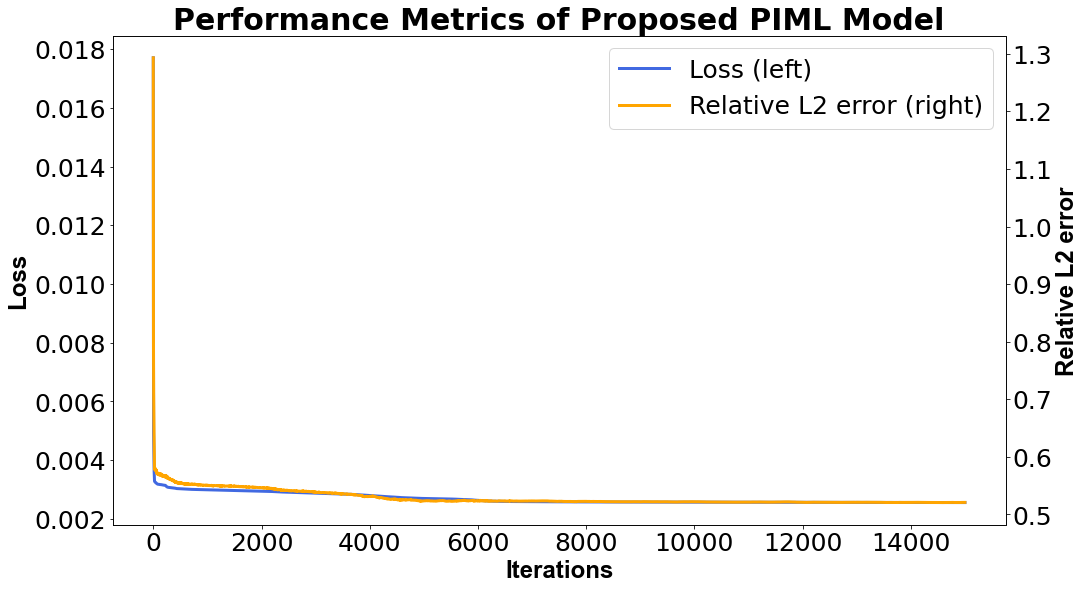

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.021028525220846934
MSE =  0.0030193108249660957
RMSE =  0.054948255886480106
L2 relative error = 0.5139267720698095
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

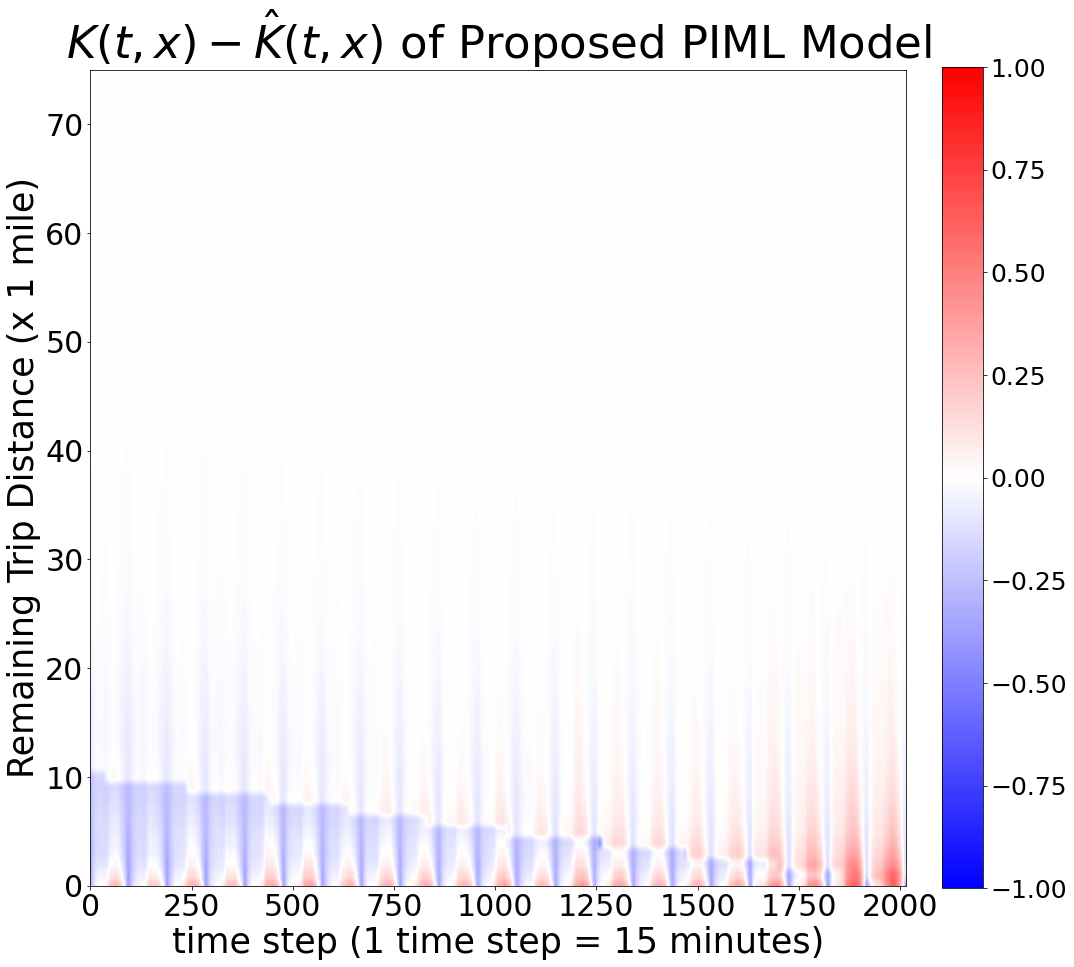

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

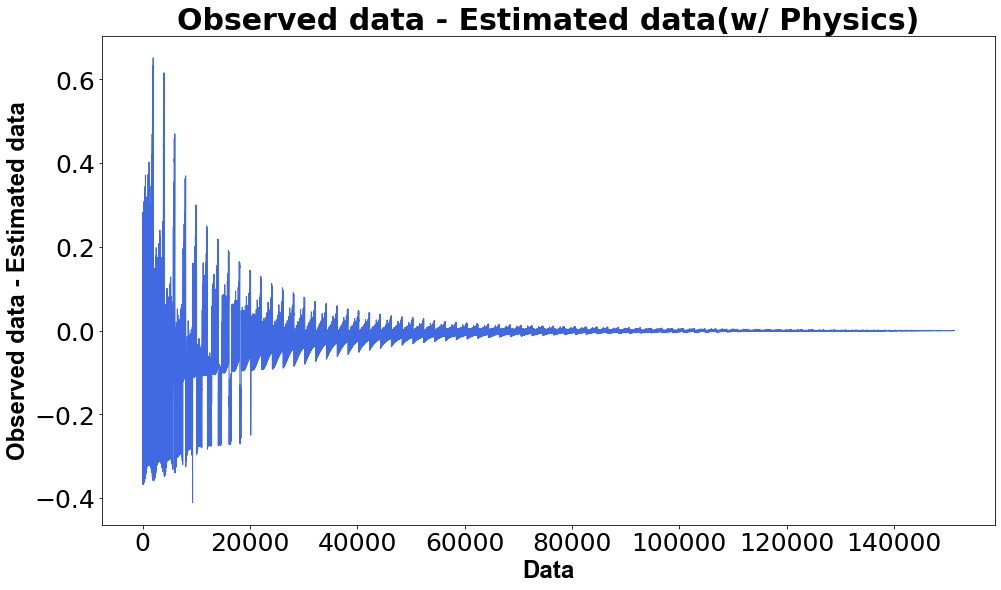

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

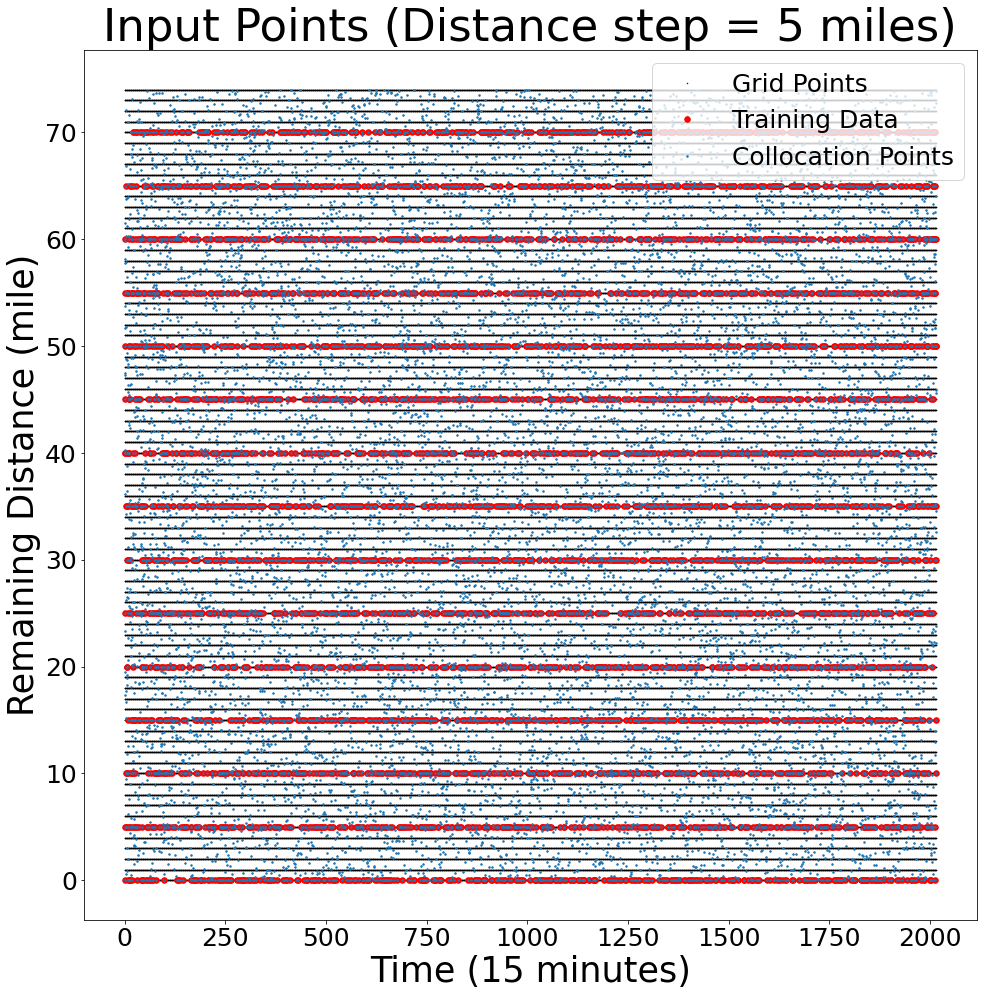

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

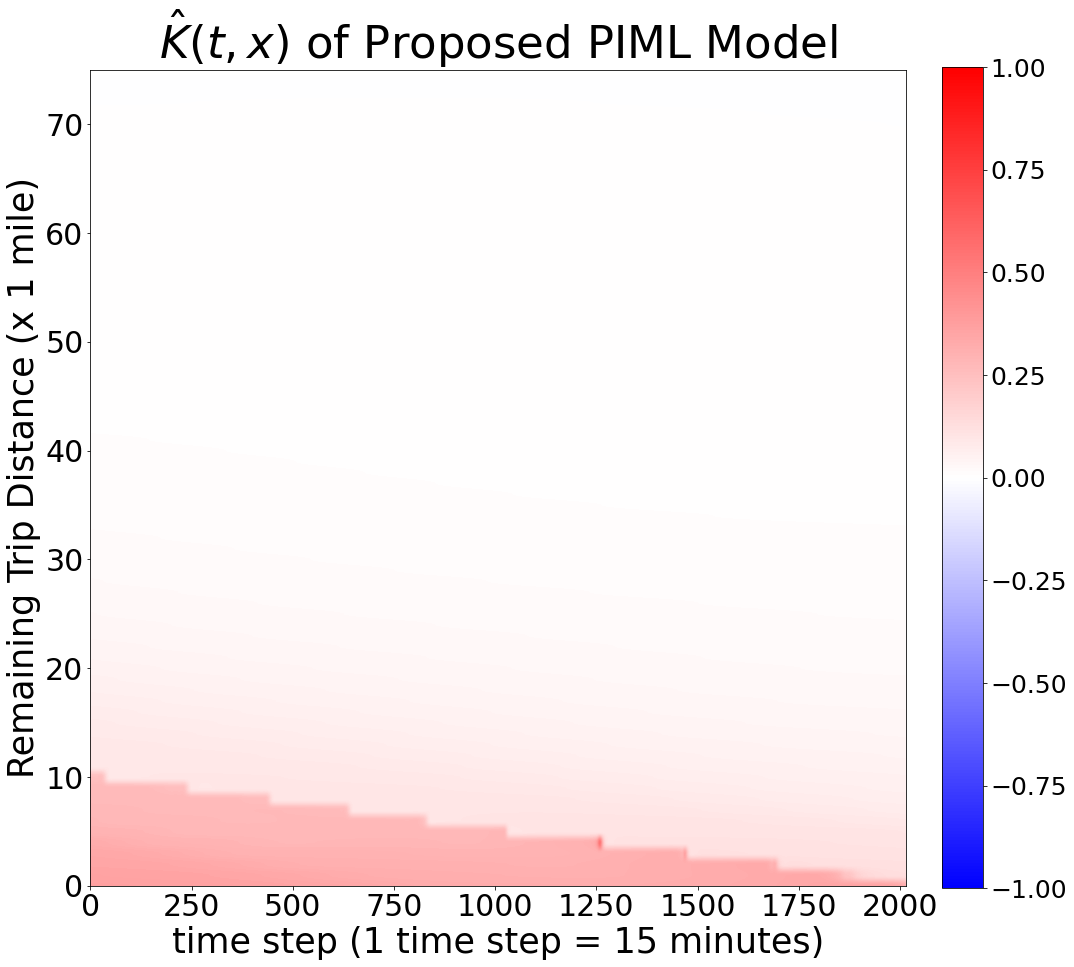

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)